# Amazon Apparel Recommendations
### Problem : List out Similar apparels to a given apparel

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [174]:
from nltk.corpus import stopwords
import re
from collections import Counter
from PIL import Image
import requests
from io import BytesIO
from matplotlib import gridspec
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)

**Loading Data**

In [4]:
data=pd.read_json('tops_fashion.json')

In [5]:
data.head()

asin author                         availability availability_type  \
0  B016I2TS4W   None                                 None              None   
1  B01N49AI08   None                                 None              None   
2  B01JDPCOHO   None                                 None              None   
3  B01N19U5H5   None                                 None              None   
4  B004GSI2OS   None  Usually ships in 6-10 business days               now   

          brand              color editorial_reivew  \
0         FNC7C               None              NaN   
1  FIG Clothing               None              NaN   
2  FIG Clothing               None              NaN   
3       Focal18               None              NaN   
4   FeatherLite  Onyx Black/ Stone              NaN   

                                    editorial_review formatted_price  \
0  Minions Como Superheroes Ironman Women's O Nec...            None   
1  Sizing runs on the small side. FIG® recommends...            None   
2  Sizing runs on the small side. FIG® recommends...            None   
3  100% Brand New & Fashion<br> Quantity: 1 Piece...            None   
4                                                             $26.26   

                                     large_image_url manufacturer  \
0  https://images-na.ssl-images-amazon.com/images...         None   
1  https://images-na.ssl-images-amazon.com/images...         None   
2  https://images-na.ssl-images-amazon.com/images...         None   
3  https://images-na.ssl-images-amazon.com/images...         None   
4  https://images-na.ssl-images-amazon.com/images...         None   

                                    medium_image_url model product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   

  publisher                                            reviews   sku  \
0      None  [False, https://www.amazon.com/reviews/iframe?...  None   
1      None  [False, https://www.amazon.com/reviews/iframe?...  None   
2      None  [False, https://www.amazon.com/reviews/iframe?...  None   
3      None  [True, https://www.amazon.com/reviews/iframe?a...  None   
4      None  [False, https://www.amazon.com/reviews/iframe?...  None   

                                     small_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title  
0  Minions Como Superheroes Ironman Long Sleeve R...  
1                      FIG Clothing Womens Izo Tunic  
2                        FIG Clothing Womens Won Top  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  
4  Featherlite Ladies' Long Sleeve Stain Resistan...

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183138 entries, 0 to 183137
Data columns (total 19 columns):
asin                 183138 non-null object
author               1 non-null object
availability         24532 non-null object
availability_type    24559 non-null object
brand                182987 non-null object
color                64956 non-null object
editorial_reivew     180380 non-null object
editorial_review     2758 non-null object
formatted_price      28395 non-null object
large_image_url      183138 non-null object
manufacturer         42899 non-null object
medium_image_url     183138 non-null object
model                62370 non-null object
product_type_name    183138 non-null object
publisher            42899 non-null object
reviews              183138 non-null object
sku                  363 non-null object
small_image_url      183138 non-null object
title                183138 non-null object
dtypes: object(19)
memory usage: 26.5+ MB


In [6]:
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')



**Using only 6 Features out of 19**

In [7]:
data=data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

**Basic Stats about Features**

In [8]:
data.describe()

asin   brand  color  \
count       183138  182987  64956   
unique      183138   10577   7380   
top     B071VS3TC4    Zago  Black   
freq             1     223  13207   

                                         medium_image_url product_type_name  \
count                                              183138            183138   
unique                                             170782                72   
top     https://images-na.ssl-images-amazon.com/images...             SHIRT   
freq                                                   23            167794   

                                                    title formatted_price  
count                                              183138           28395  
unique                                             175985            3135  
top     Nakoda Cotton Self Print Straight Kurti For Women          $19.99  
freq                                                   77             945

**Observations**:
-  Total Unique Brands : 10577
-  Top Brand : Zago
-  Total Unique Product Type Names : 72
-  Top Product Type : Shirt

### Removing Null Values

In [12]:
data=data.dropna()

In [16]:
print('Total Apparels Left  : ',data.shape[0])

Total Apparels Left  :  28292


In [17]:
data.to_pickle('apparel_data_1.pickle')

In [20]:
data = pd.read_pickle('apparel_data_1.pickle')

# find number of products that have duplicate titles.
print('Number of Products with Duplicate titles:',sum(data.duplicated('title')))

Number of Products with Duplicate titles: 2323


In [25]:
data=data.drop_duplicates('title')
print('Number of Products Left after duplicates remove:',data.shape[0])

Number of Products Left after duplicates remove: 25969


In [26]:
data = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data.shape[0])

After removal of products with short description: 25722


In [28]:
data.sort_values('title',inplace=True, ascending=False)
data.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

**Removing titles which Duplicates to some extent**

##### 1. At End

In [30]:
#Getting Indices
indices = []
for i,row in data.iterrows():
    indices.append(i)

In [ ]:
import itertools

asins1 = []
i = 0
j = 0
ndata= data.shape[0]
while i < ndata and j < ndata:
    pr_i = i
    a = data['title'].loc[indices[i]].split()

    j = i+1
    while j < ndata:
        b = data['title'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            asins1.append(data['asin'].loc[indices[i]])

            
            if j == ndata-1: asins1.append(data['asin'].loc[indices[j]])

            
            i = j
            break
        else:
            j += 1
    if pr_i == i:
        break

In [ ]:
data = data.loc[data['asin'].isin(asins1)]

In [40]:
print('Data items left after removing duplicates at end:',data.shape[0])

Data items left after removing duplicates at end: 17593


In [ ]:
data.to_pickle('apperal_data_2.pickle')

In [39]:
data=pd.read_pickle('apperal_data_2.pickle')

#### 2. In Between and Beginning

In [ ]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

asins2 = []
while len(indices)!=0:
    i = indices.pop()
    asins2.append(data['asin'].loc[i])
    a = data['title'].loc[i].split()
    
    for j in indices:
        
        b = data['title'].loc[j].split()
        length = max(len(a),len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
                if (k[0]==k[1]):
                    count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
data = data.loc[data['asin'].isin(asins2)]

In [42]:
print('Data items left after removing duplicates at other then end:',data.shape[0])

Data items left after removing duplicates at other then end: 16042


In [ ]:
data.to_pickle('apparel_data_3')

In [41]:
data = pd.read_pickle('apparel_data_3')

In [55]:
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [56]:
%%time
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

Wall time: 5.4 s


### Utility functions

In [57]:
def display_image(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    

In [58]:
def plot_heatmap(keys, values, labels, url, text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        #Plot1
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys)
        ax.set_title(text)
        
        #Plot2
        ax=plt.subplot(gs[1])
        ax.grid(False)
        display_image(url,ax,fig)
        
        plt.show()
    

In [118]:
def data_plots(doc_id, vec1, vec2, url, text, model):
    #common words
    intersection = set(vec1.keys()) & set(vec2.keys())
    
    for i in vec2:
        if(i not in intersection):
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    
    if(model=='bow'):
        labels=values
    elif (model=='tfidf'):
        labels=[]
        for x in keys:
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys,values,labels,url,text)

In [60]:
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    #return Word:freq
    return Counter(words)

In [62]:
def result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    data_plots(doc_id, vector1, vector2, url, text2, model)

## Bag of Words

In [85]:
vectorizer = CountVectorizer()
title_features   = vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

In [77]:
def bag_of_words(docid,numr):
    pairwise_dist = pairwise_distances(title_features,title_features[docid])
    indices = np.argsort(pairwise_dist.flatten())[0:numr]
    pdists  = np.sort(pairwise_dist.flatten())[0:numr]
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bow')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

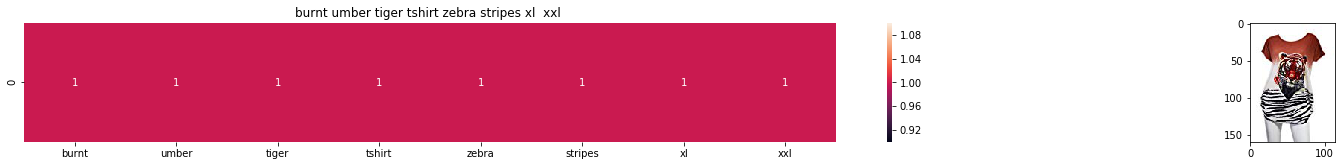

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


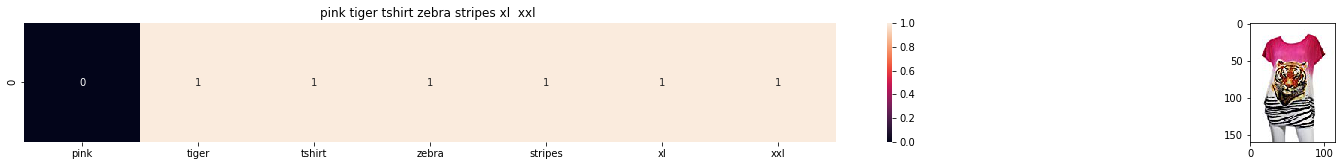

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


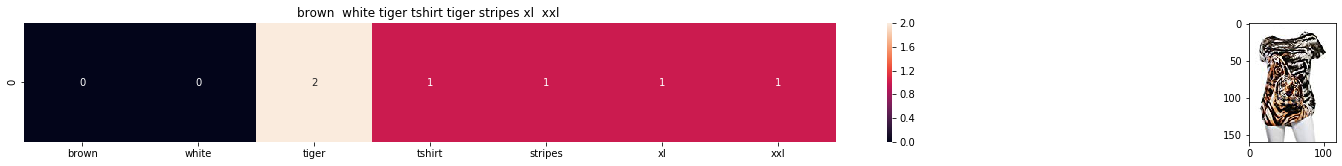

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


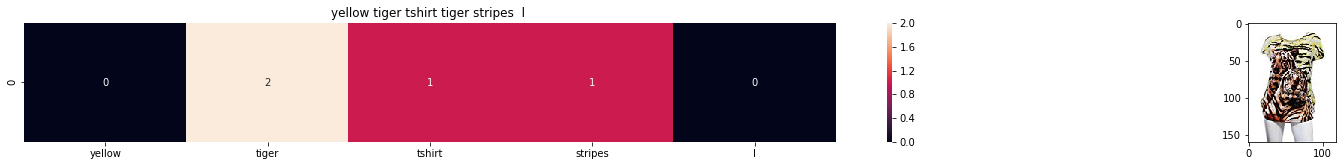

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


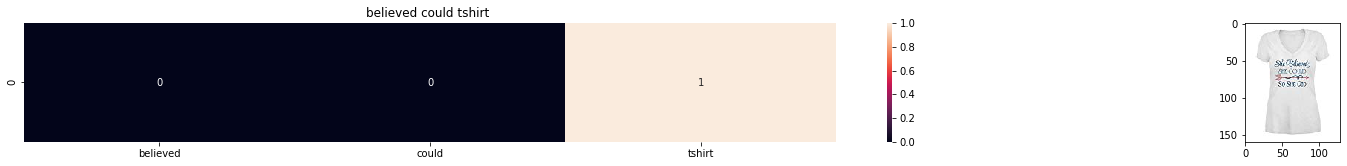

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


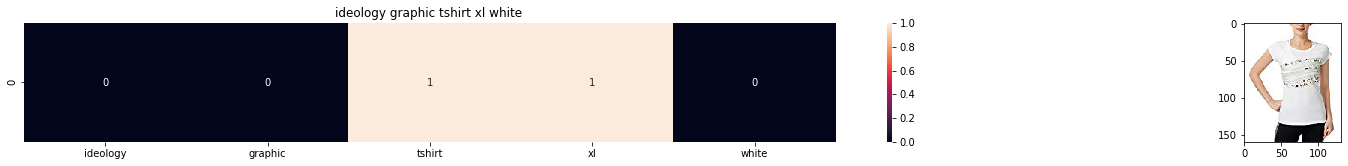

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


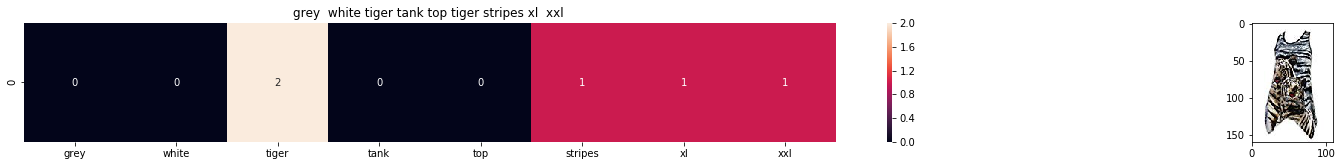

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


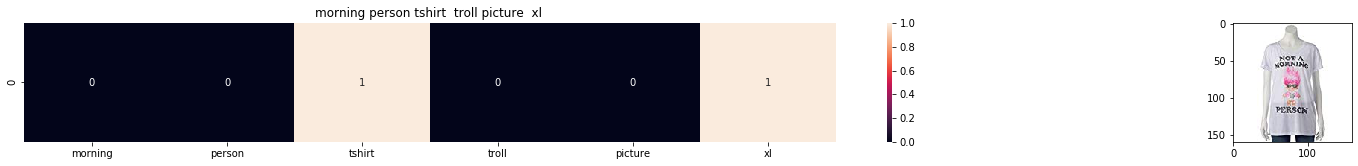

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


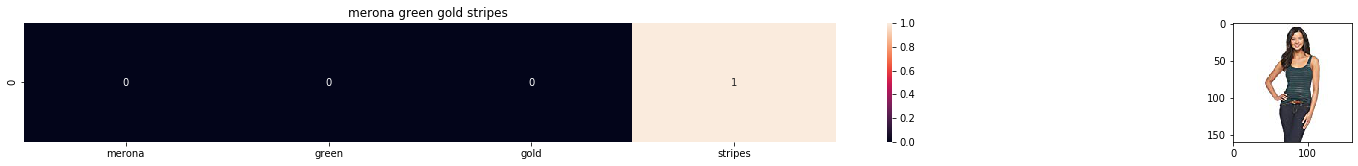

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


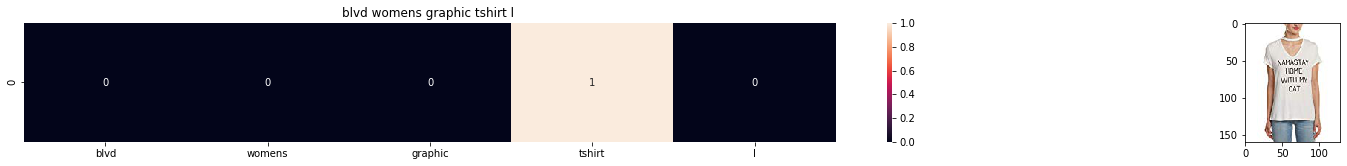

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


In [119]:
bag_of_words(12566, 10)

## Tf-idf 

In [111]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

In [89]:
def tfidf(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        
        result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)

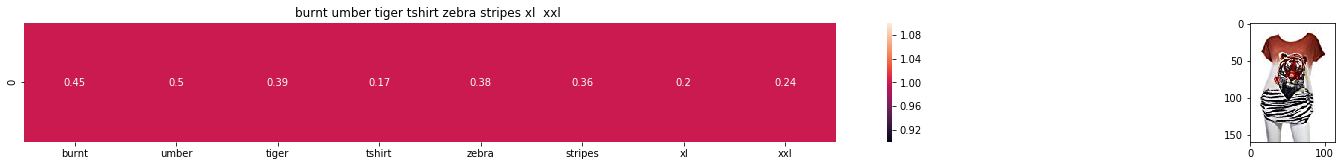

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


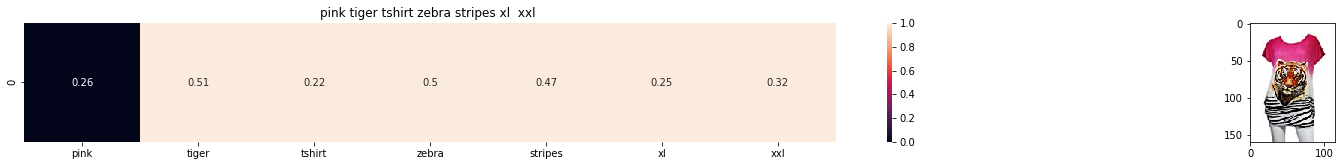

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451361


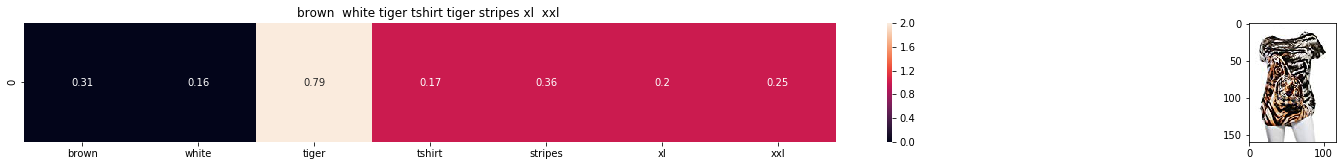

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769645


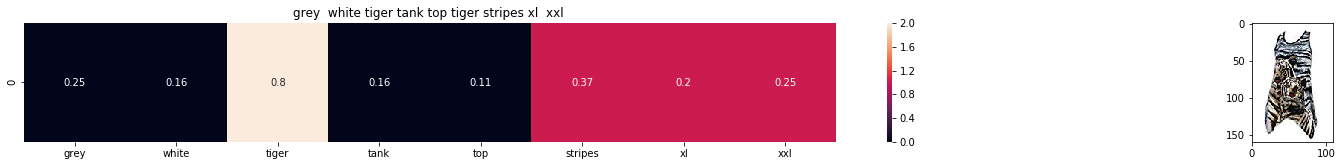

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


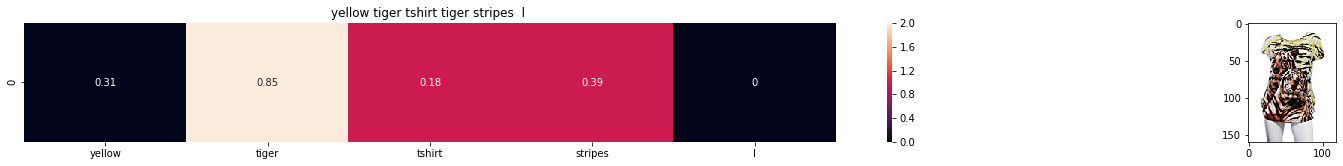

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


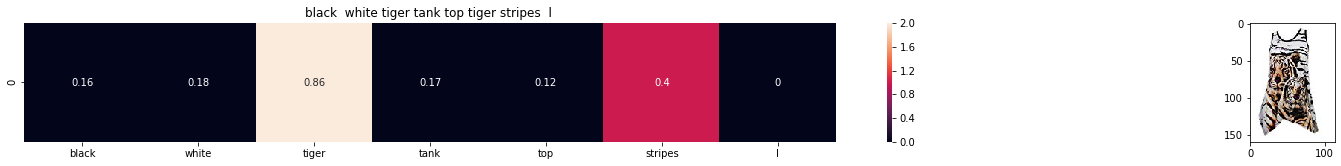

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.023215552457452


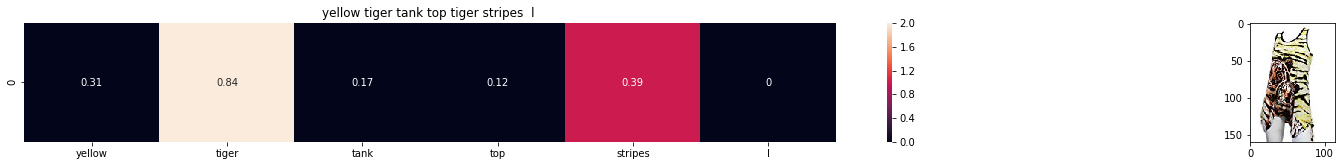

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.031991846303421


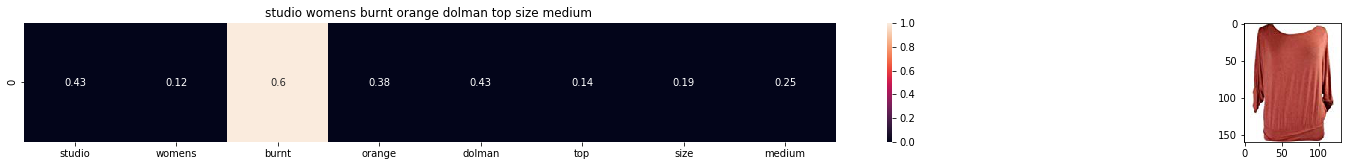

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.2106843670424716


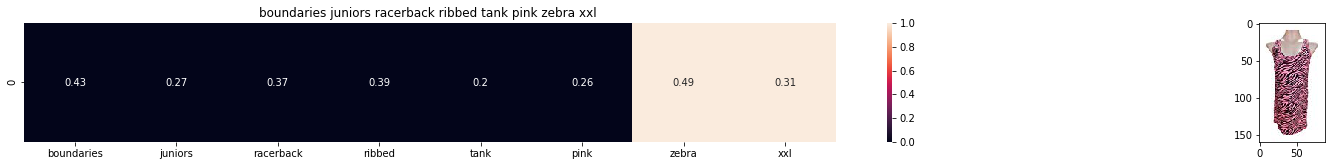

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.212168381072083


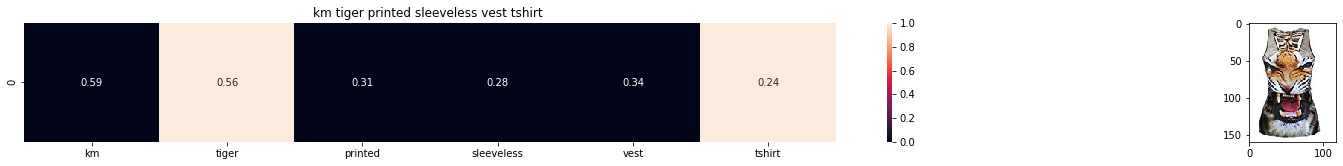

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.219790640280982


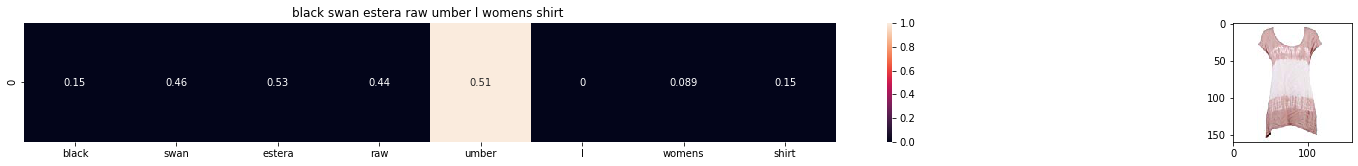

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.2206849659998316


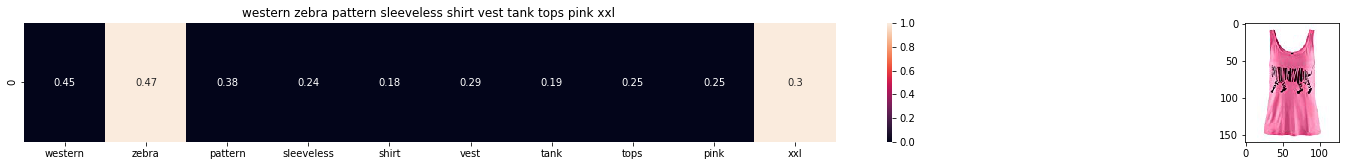

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.221281392120943


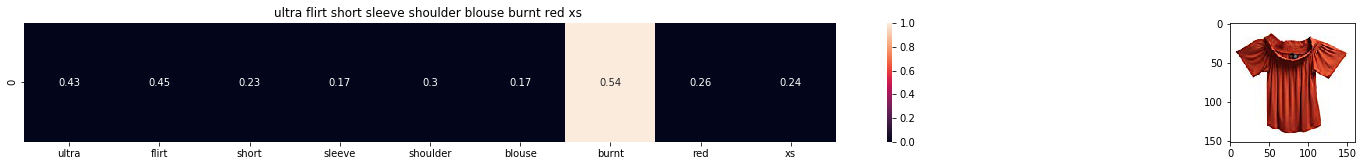

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2313364094597743


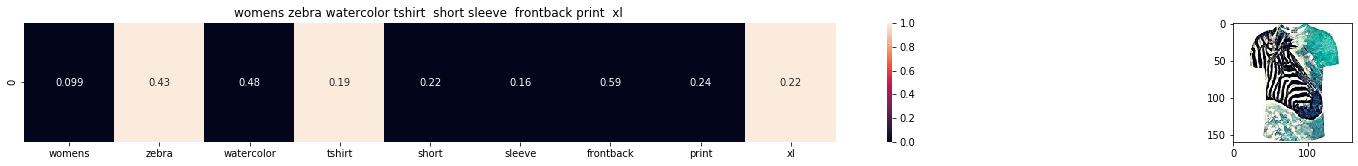

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.2318451972624518


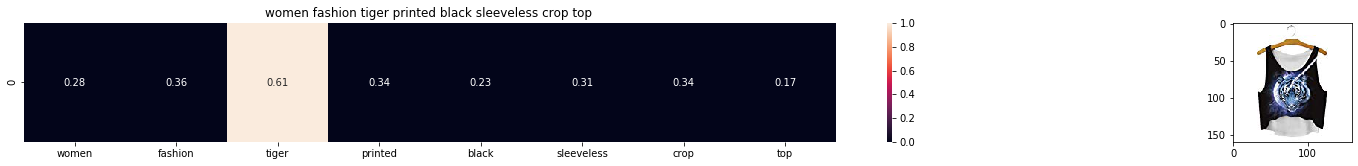

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.2340607457359425


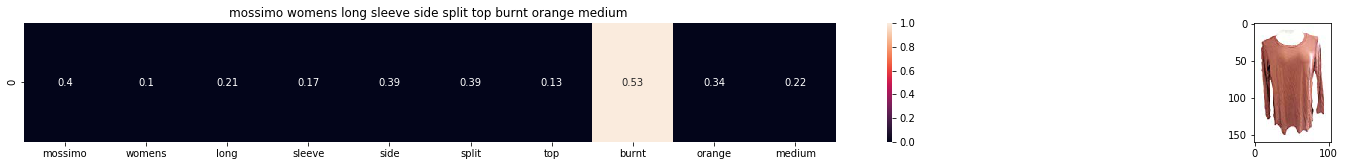

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.2352785577664824


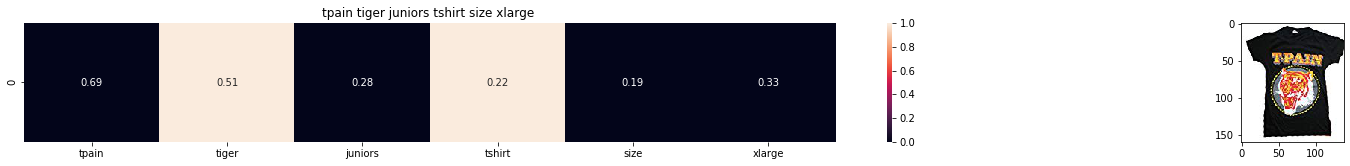

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.236457298812782


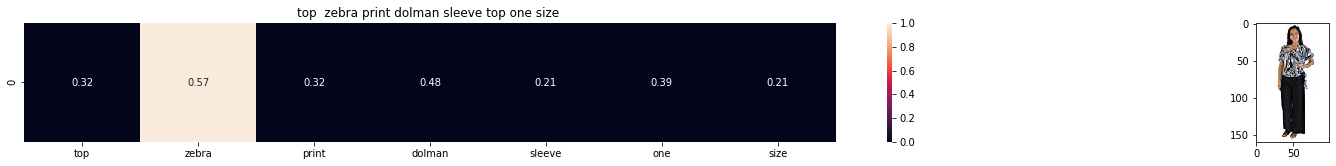

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155052848


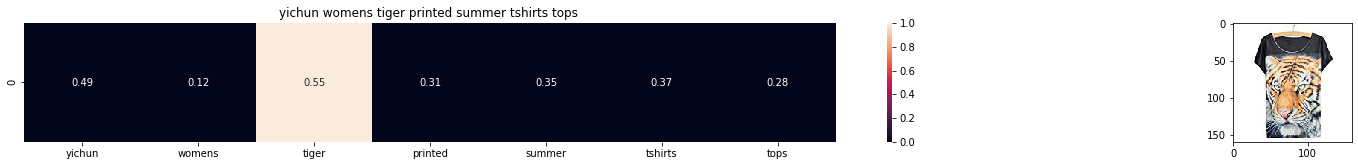

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.25354614208561


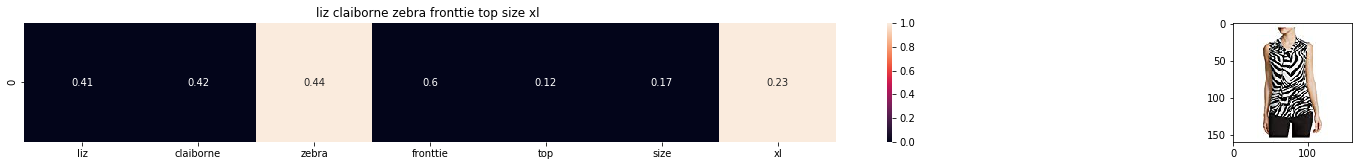

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.2538832938357722


In [120]:
tfidf(12566, 20)

## Word2Vec

In [121]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [122]:
with open('word2vec_model', 'rb') as f:
    model = pickle.load(f)

**Utility functions for Word2vec**

In [160]:
def get_wordvec(sentence,doc_id,mod):
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if mod == 'weighted' and i in  tfidf_title_vectorizer.vocabulary_:
                vec.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[i]] * model[i])
            elif mod == 'avg':
                vec.append(model[i])
        else:
            # if not in corpus ignore it
            vec.append(np.zeros(shape=(300,)))
    return np.array(vec)

In [141]:
def get_dist(v1,v2):
    final_dist = []
    
    for i in v1:
        d=[]
        for j in v2:
            d.append(np.linalg.norm(i-j))
        final_dist.append(d)
    return np.array(final_dist)

In [148]:
def heatmap_w2v(sentence1, sentence2, url, doc_id1, doc_id2, mod):
    s1_v= get_wordvec(sentence1, doc_id1, mod)
    s2_v= get_wordvec(sentence2, doc_id2, mod)
    s1_s2_d= get_dist(s1_v, s2_v)
    
    #heatmap 
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    #Plot 1 heatmap
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_d,4), annot=True)
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    ax.set_title(sentence2)
    
    #Plot 2 image
    ax = plt.subplot(gs[1])
    ax.grid(False)
    display_image(url, ax, fig)
    plt.show() 

In [155]:
vocab=model.keys()

def get_avg_vec(sentence, num_features, doc_id, mod):
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    
    for w in sentence.split():
        nwords+=1
        if w in vocab:
            if(mod=='weighted' and w in tfidf_title_vectorizer.vocabulary_):
                # for each word = idf*w2v
                featureVec=np.add(featureVec,tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[w]] * model[w])
            elif mod=='avg':
                featureVec = np.add(featureVec, model[w])
    if(nwords>0):
        featureVec=np.divide(featureVec,nwords)
    return featureVec

### Avg Word2Vec

In [135]:
doc_id = 0
w2v_title = []
for i in data['title']:
    w2v_title.append(get_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1
w2v_title = np.array(w2v_title)

In [144]:
def avg_w2v(docid,numr):
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[docid].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:numr]
    pdists  = np.sort(pairwise_dist.flatten())[0:numr]
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heatmap_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

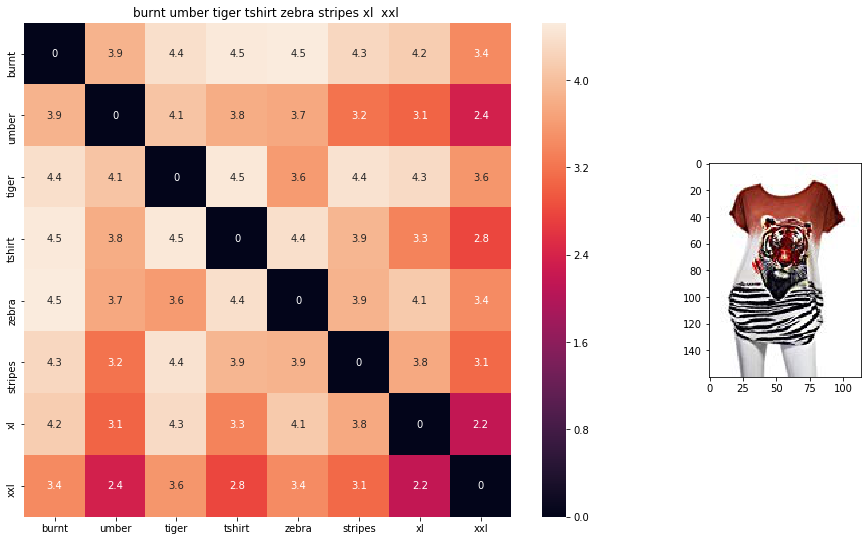

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.0


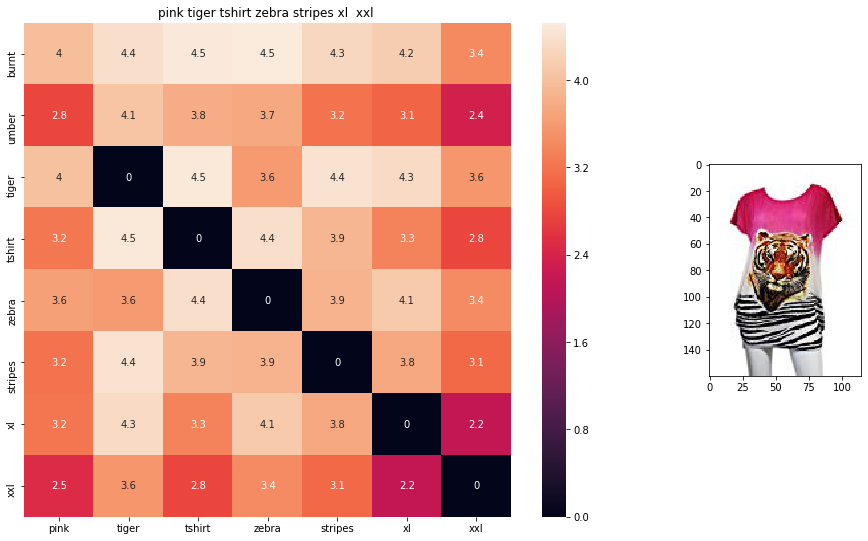

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.5891926


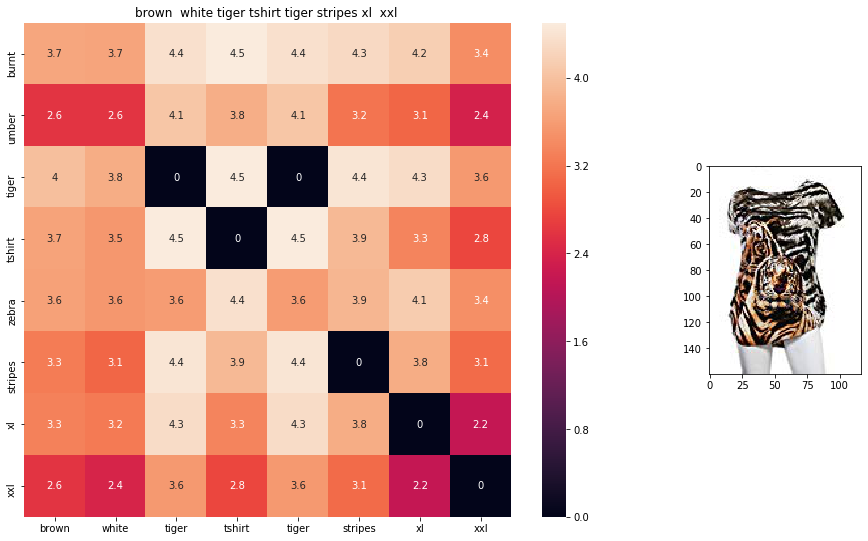

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.7003438


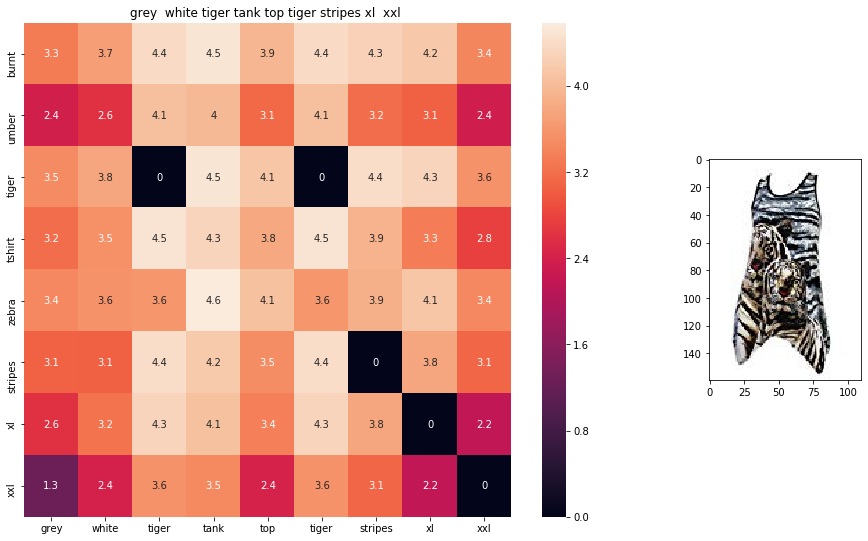

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.89283955


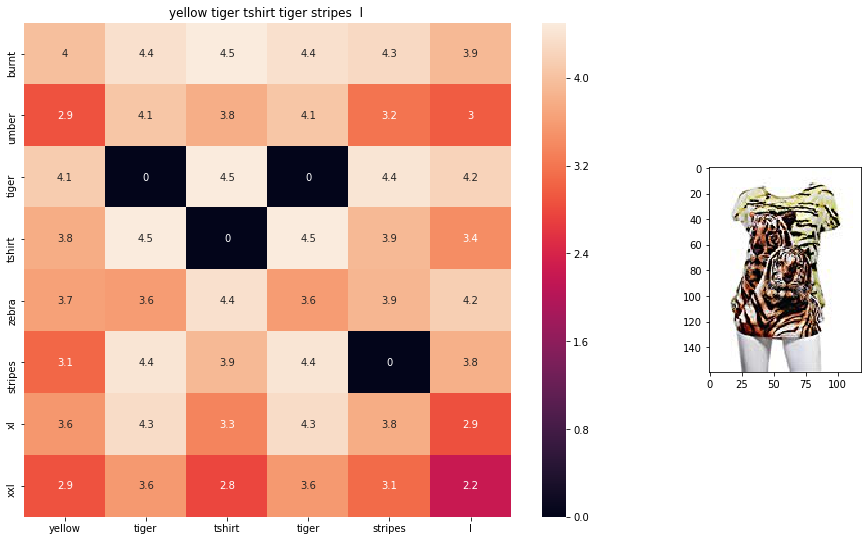

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.95601255


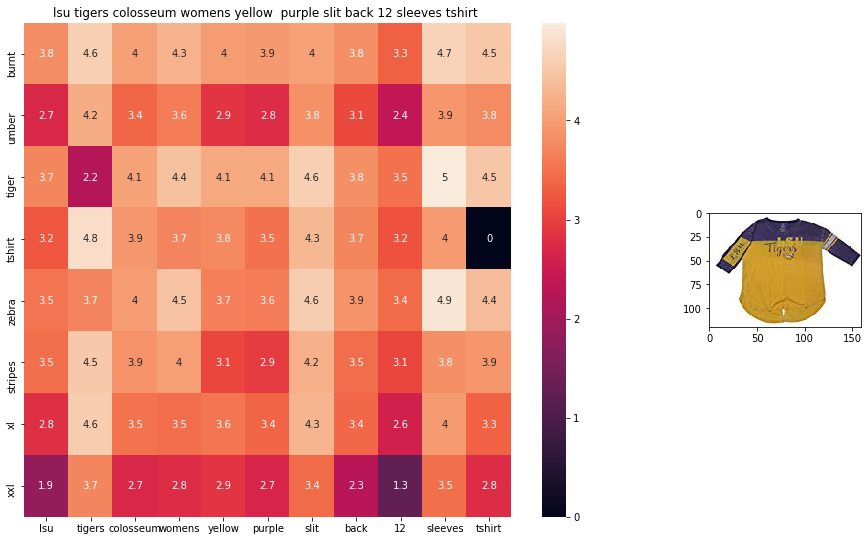

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.022969


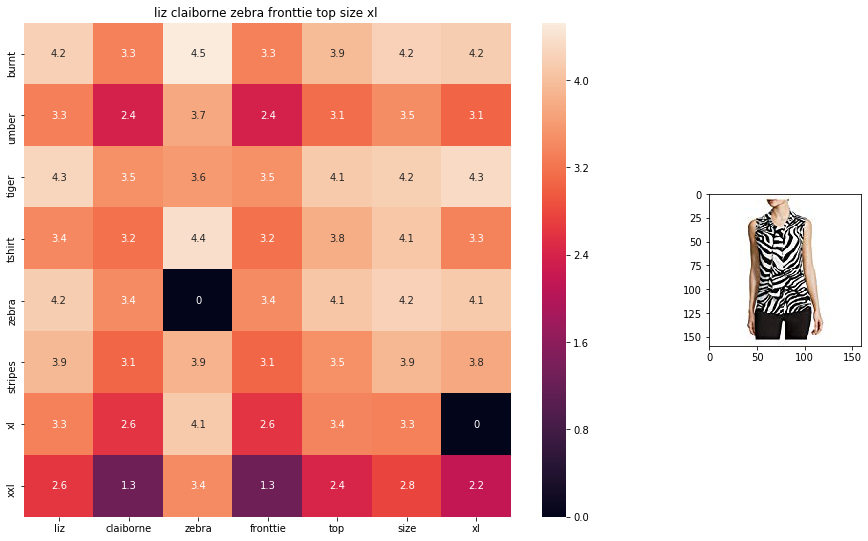

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324


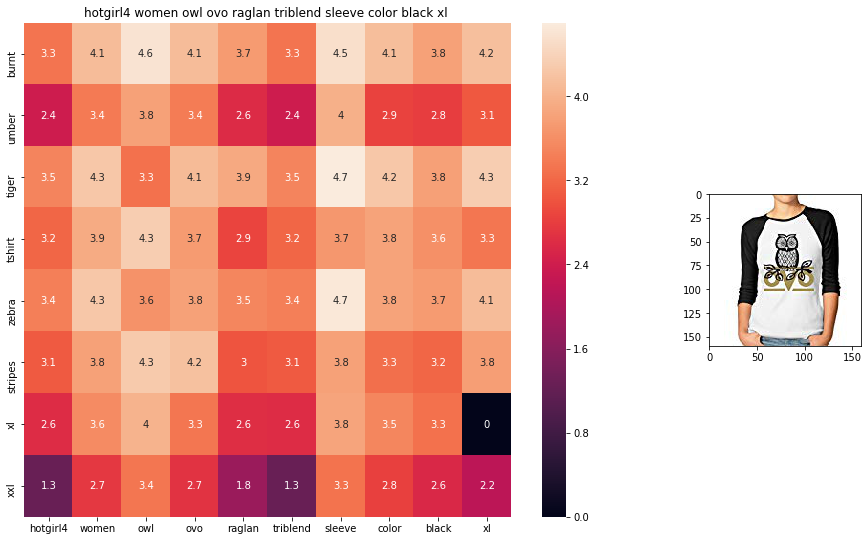

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731405


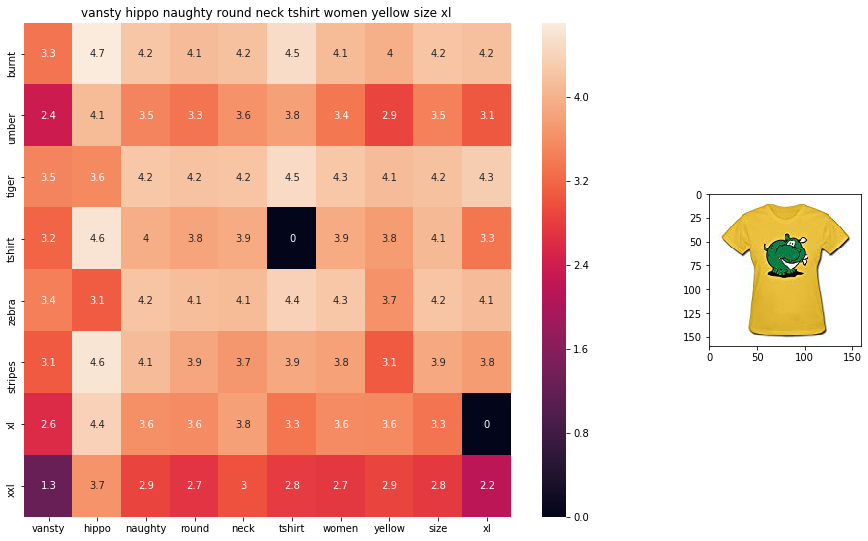

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719


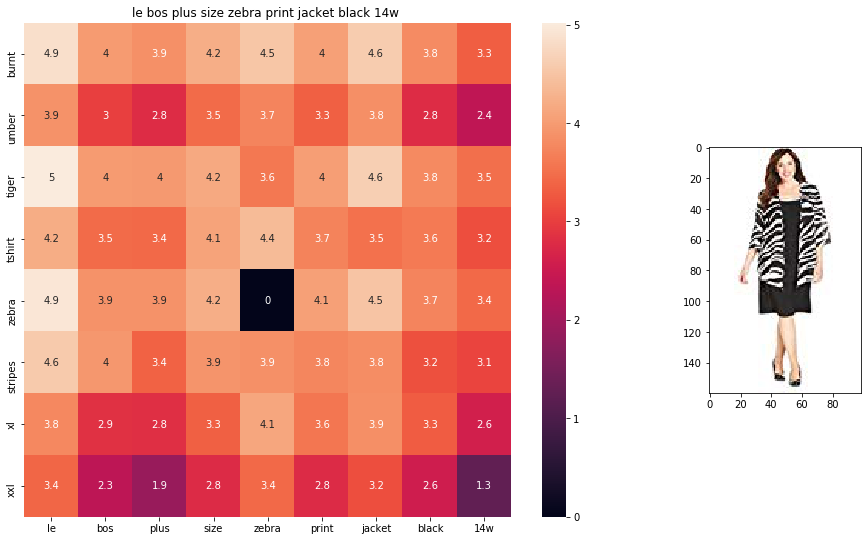

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.0839964


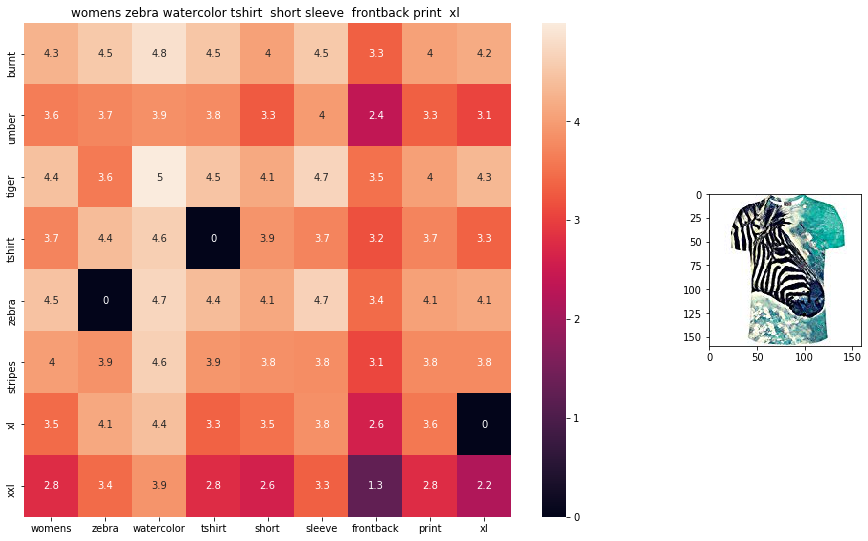

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.0842218


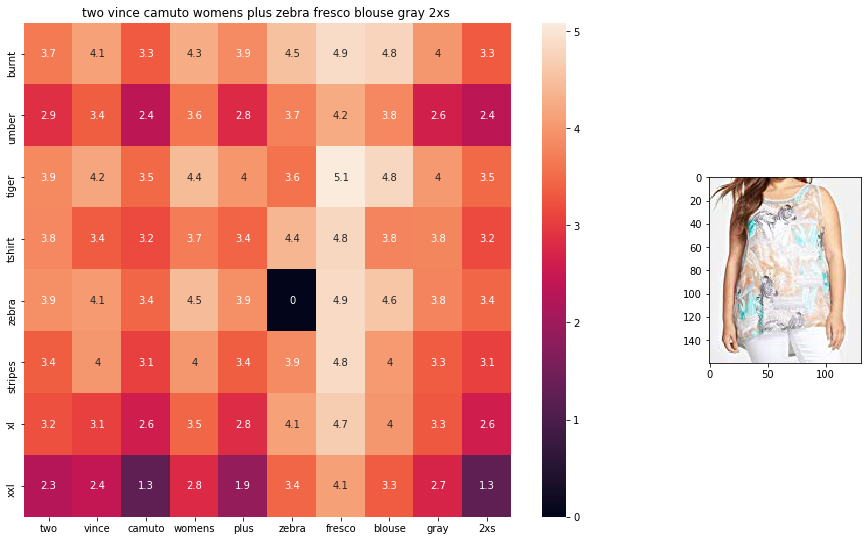

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895038


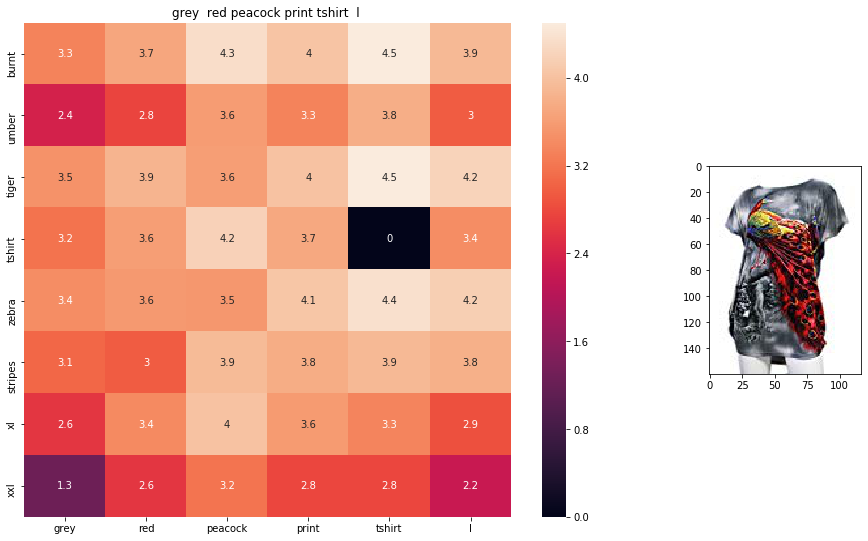

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.0900588


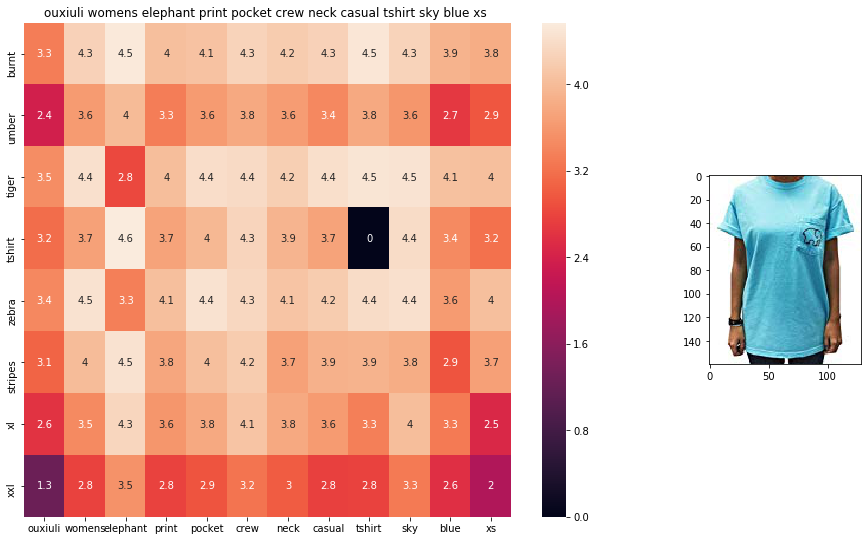

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.0920111


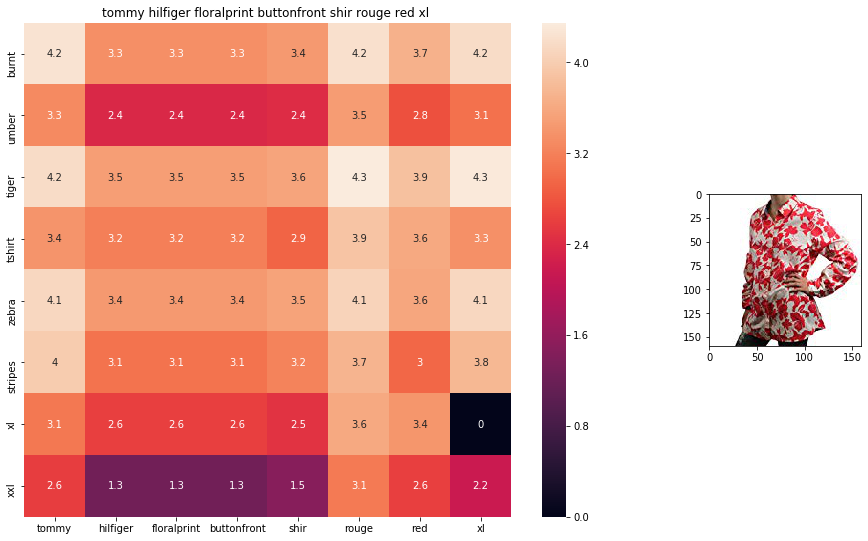

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0923415


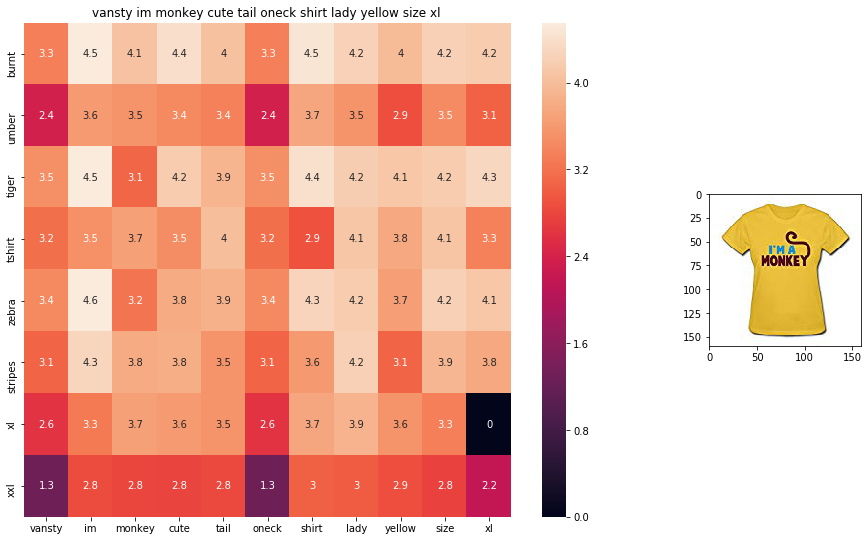

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934004


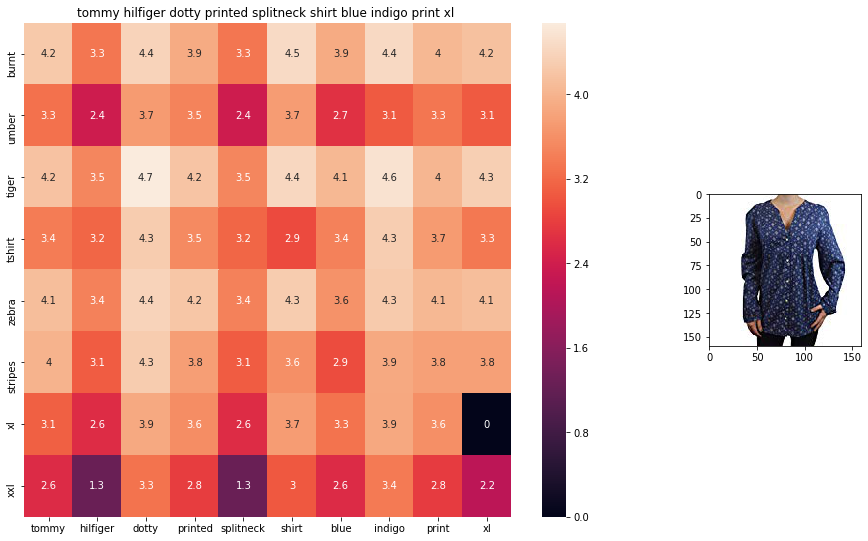

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942024


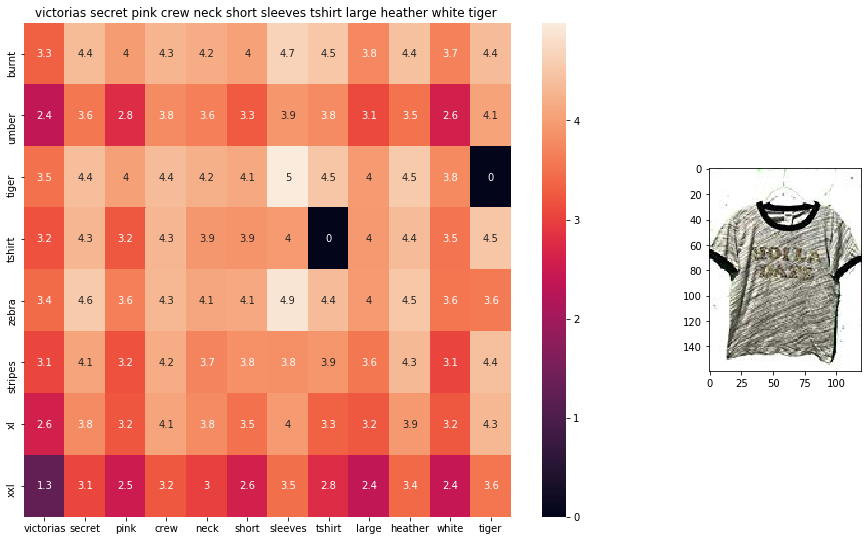

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.0948304


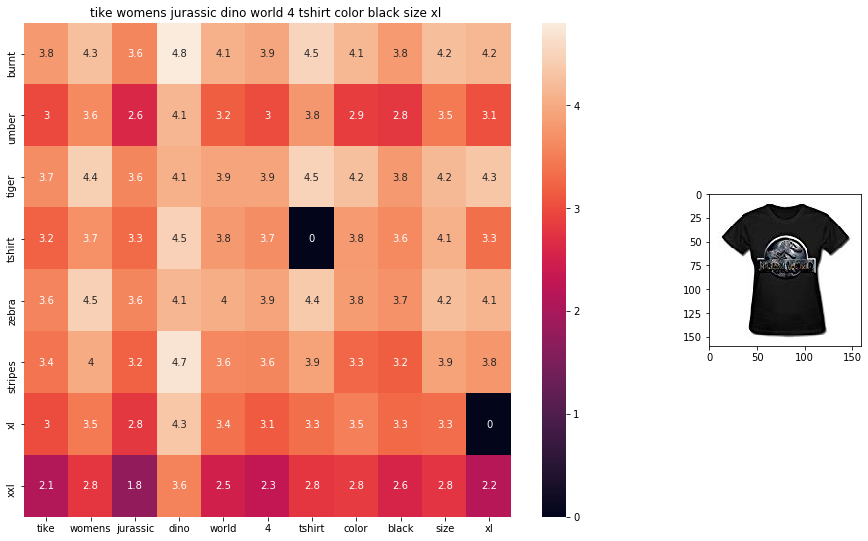

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.0951275


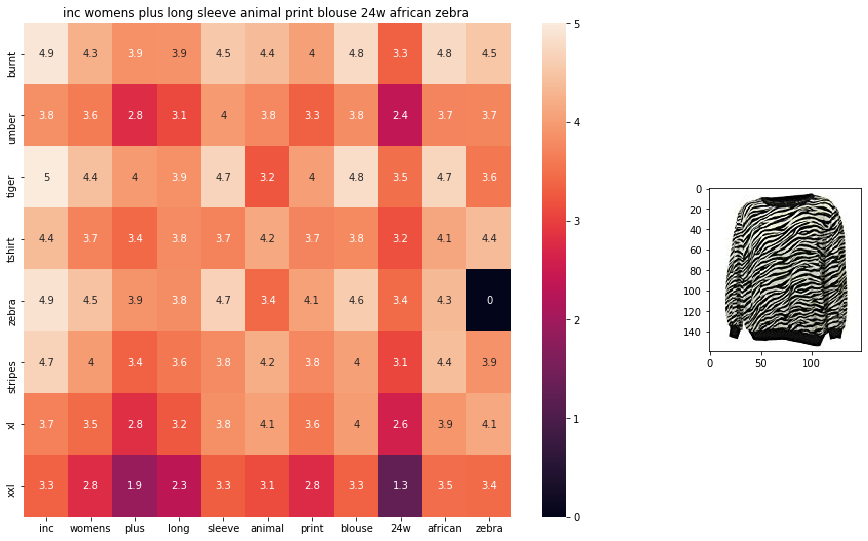

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.0966892


In [149]:
avg_w2v(12566, 20)

## TFIDF Weighted W2V

In [157]:
doc_id = 0
w2v_w = []
for i in data['title']:
    w2v_w.append(get_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1

w2v_w = np.array(w2v_w)

In [158]:
def weighted_w2v_model(docid, numr):
    pairwise_dist = pairwise_distances(w2v_w, w2v_w[docid].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:numr]
    pdists  = np.sort(pairwise_dist.flatten())[0:numr]
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heatmap_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

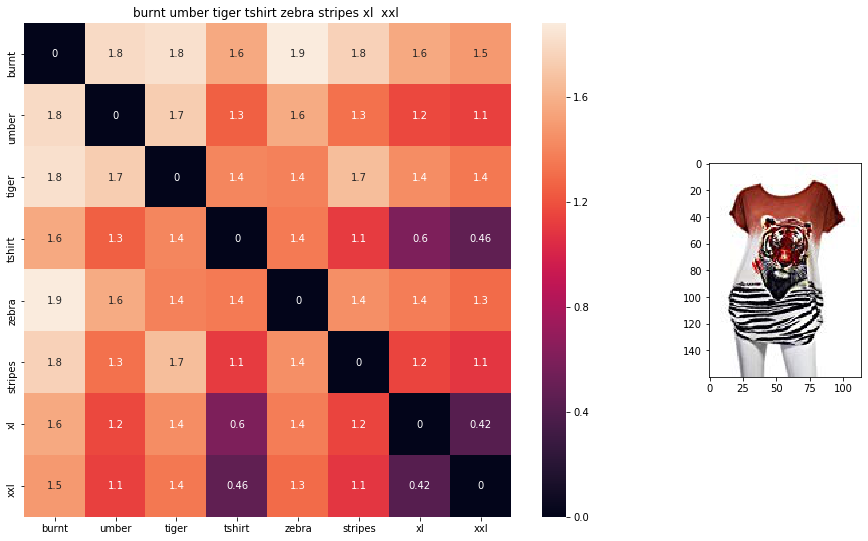

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


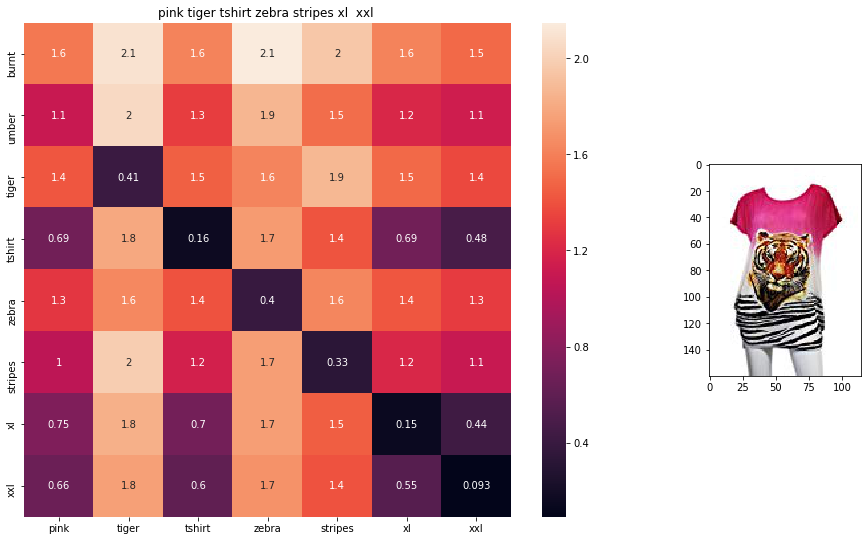

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 0.28328523


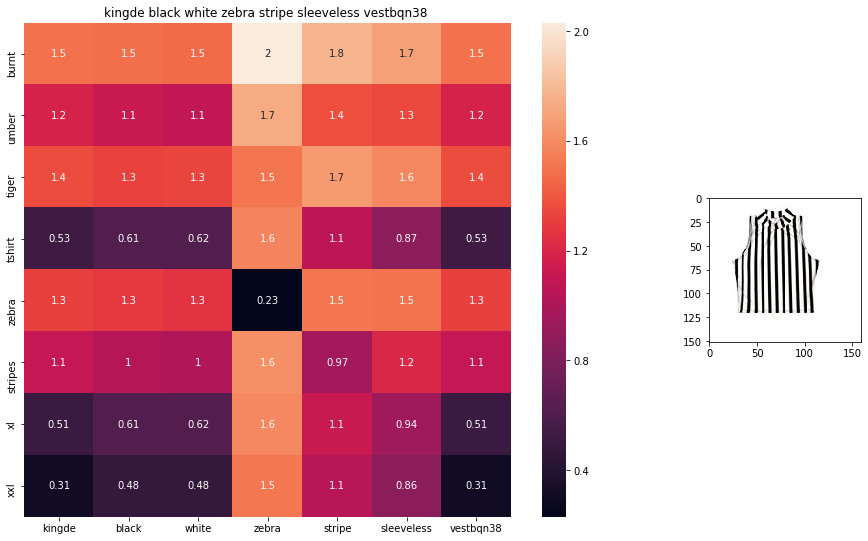

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 0.36122632


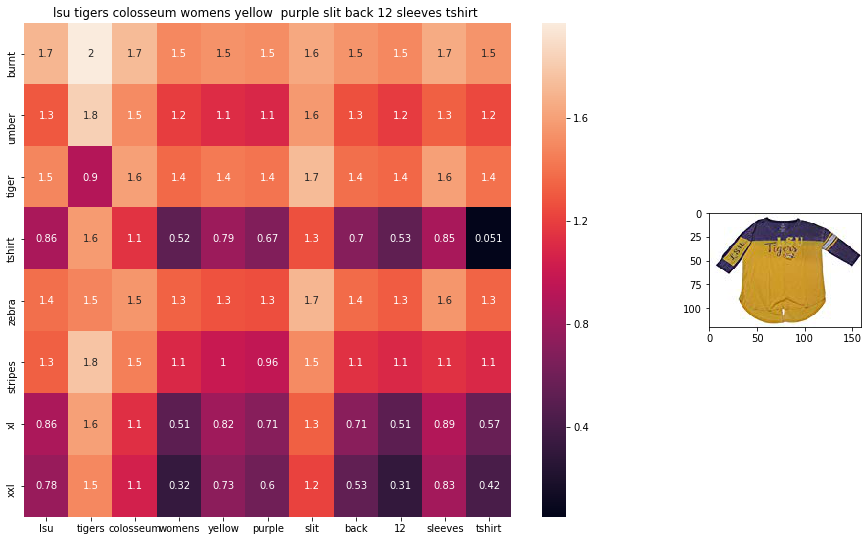

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 0.3721152


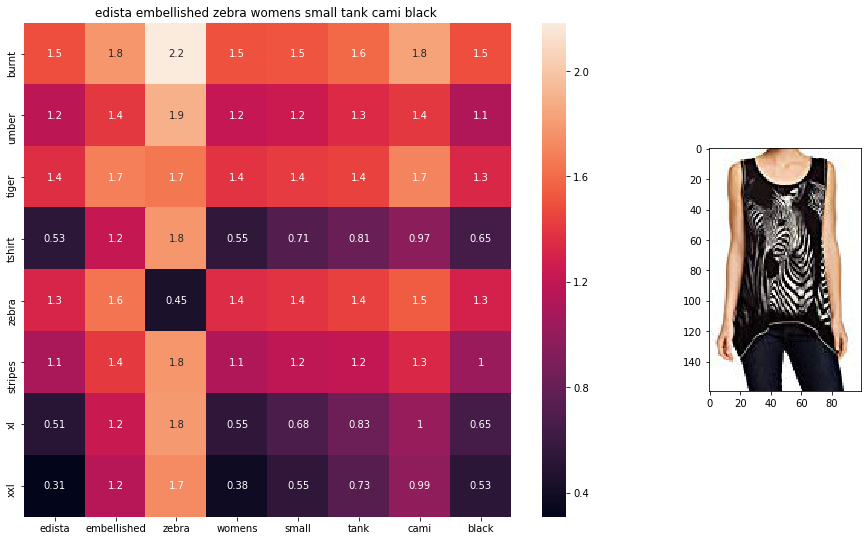

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 0.37554494


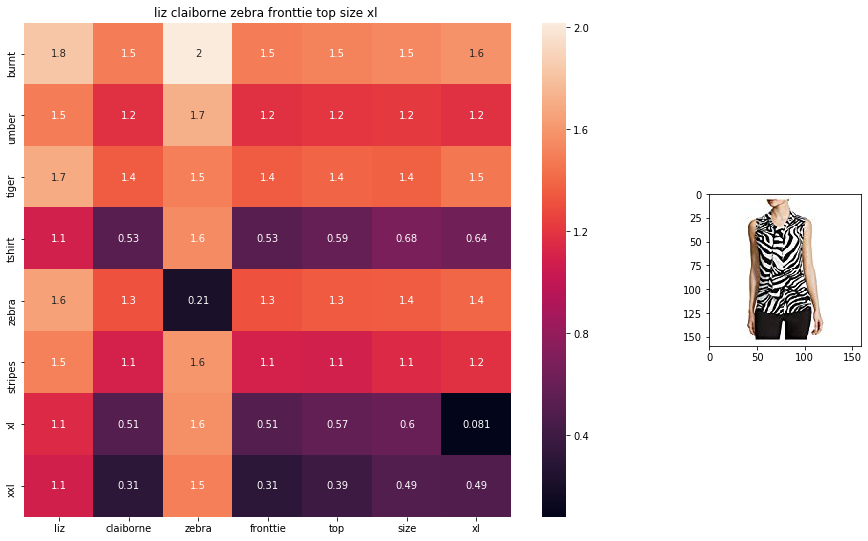

ASIN : B06XBY5QXL
Brand : Liz Claiborne
euclidean distance from input : 0.3763736


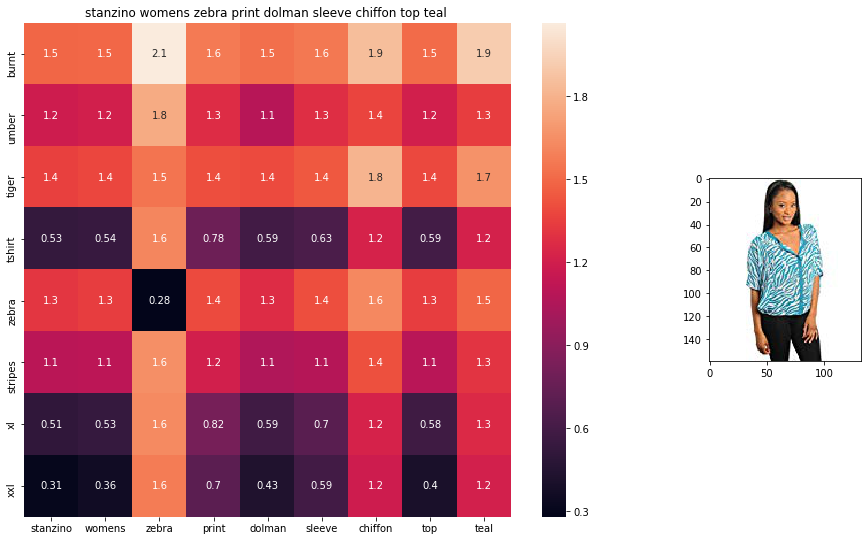

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 0.38479307


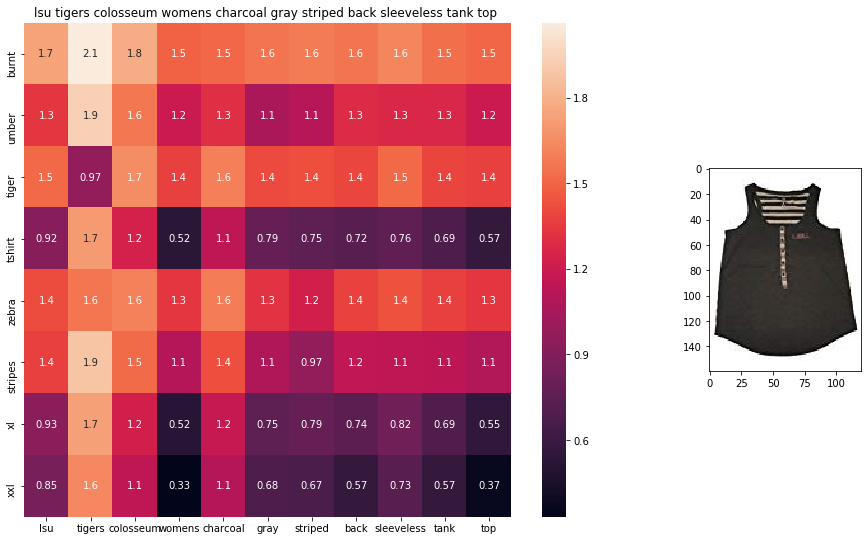

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 0.38751444


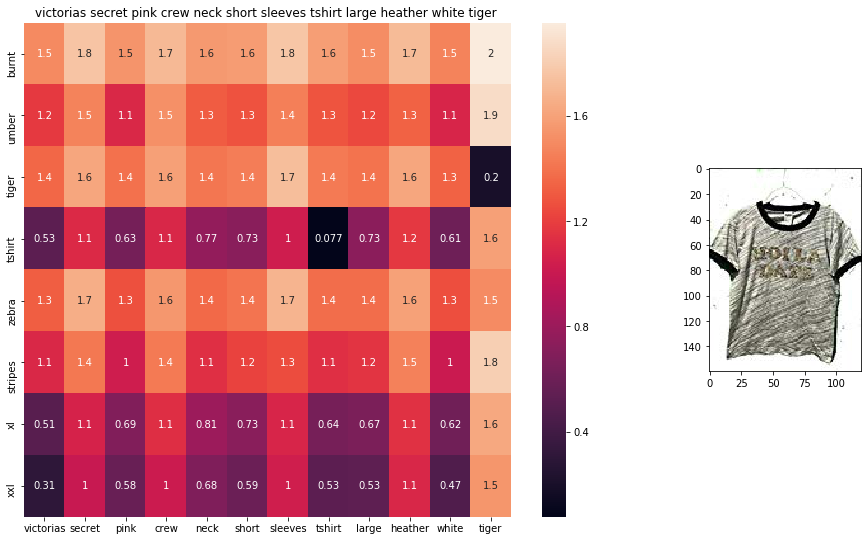

ASIN : B0716MVPGV
Brand : V.Secret
euclidean distance from input : 0.3905082


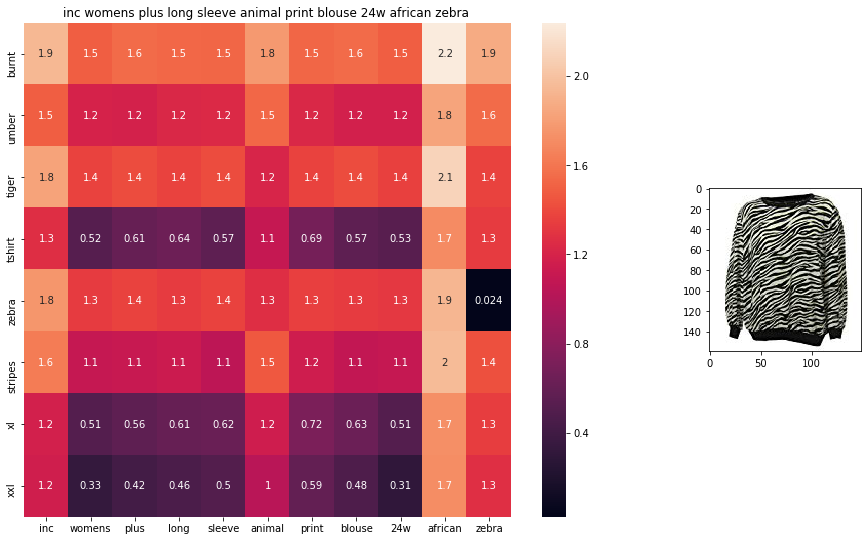

ASIN : B018WDJCUA
Brand : INC - International Concepts Woman
euclidean distance from input : 0.3956606


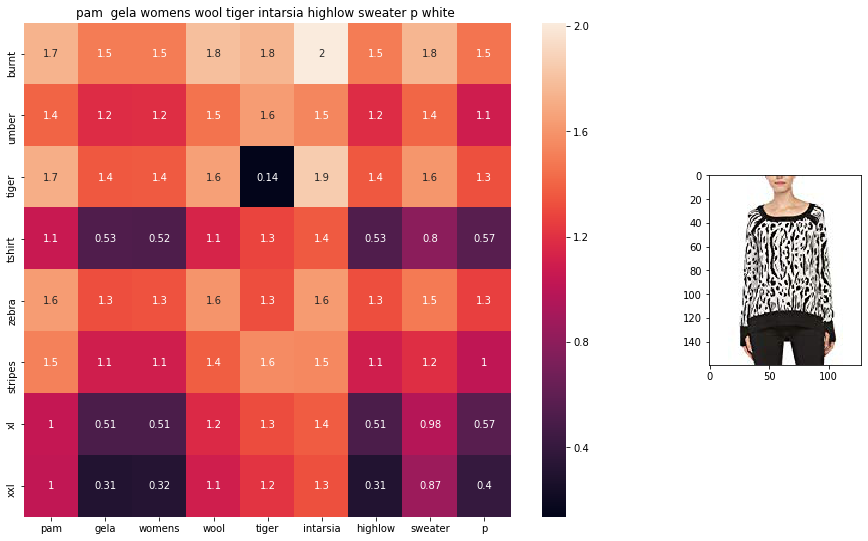

ASIN : B01MPX3HPW
Brand : Pam & Gela
euclidean distance from input : 0.40002587


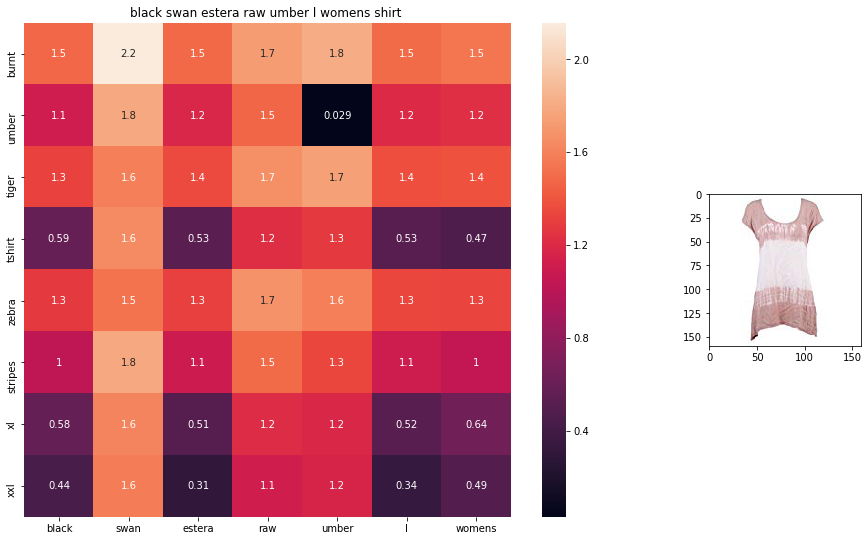

ASIN : B06Y1VN8WQ
Brand : Black Swan
euclidean distance from input : 0.40051895


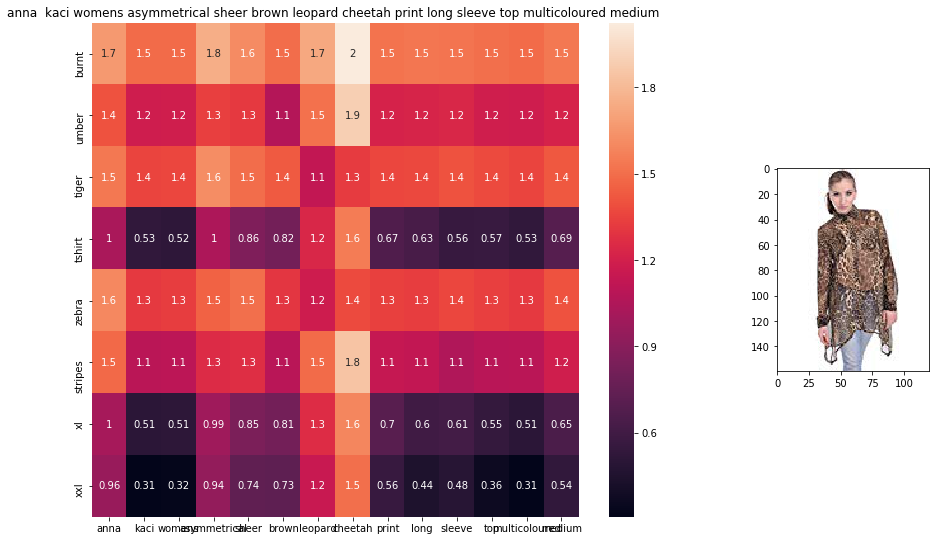

ASIN : B00KSNTY7Y
Brand : Anna-Kaci
euclidean distance from input : 0.40167603


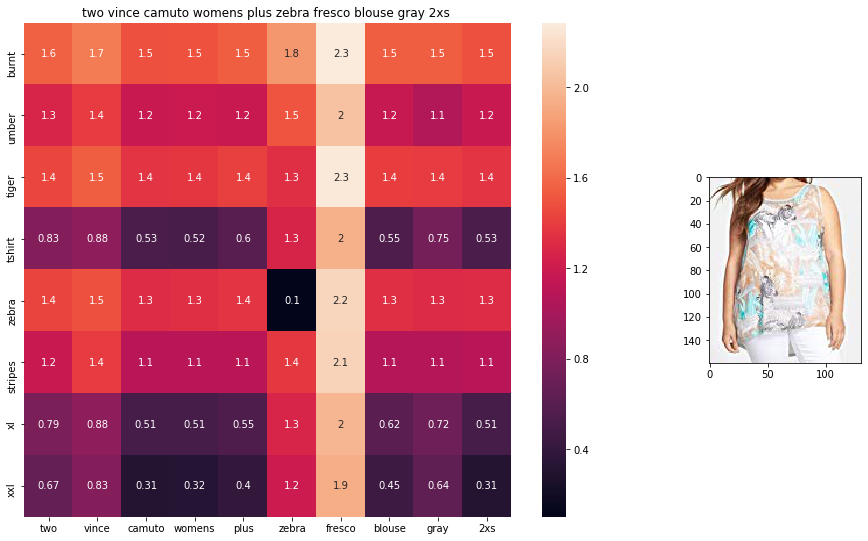

ASIN : B074MJRGW6
Brand : Two by Vince Camuto
euclidean distance from input : 0.4039892


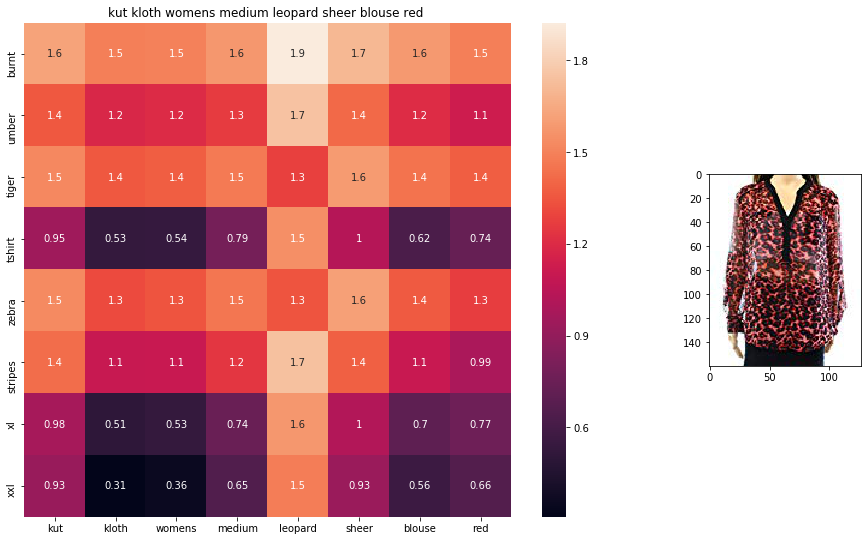

ASIN : B071G32WV3
Brand : KUT from the Kloth
euclidean distance from input : 0.40399435


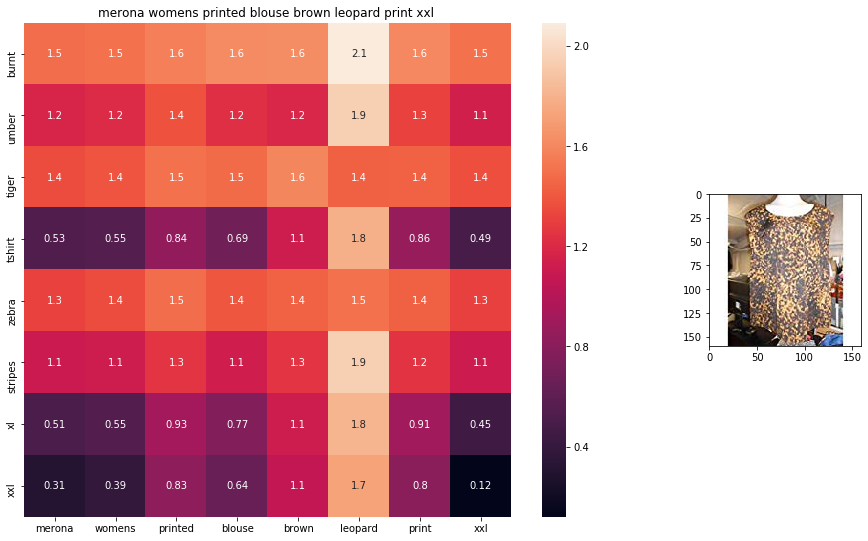

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 0.4047798


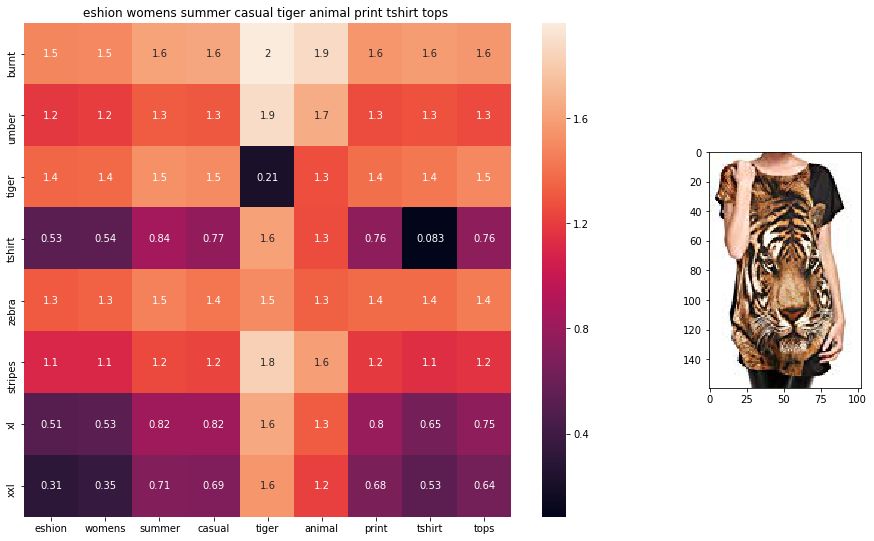

ASIN : B01EXZQR4K
Brand : eshion
euclidean distance from input : 0.4048466


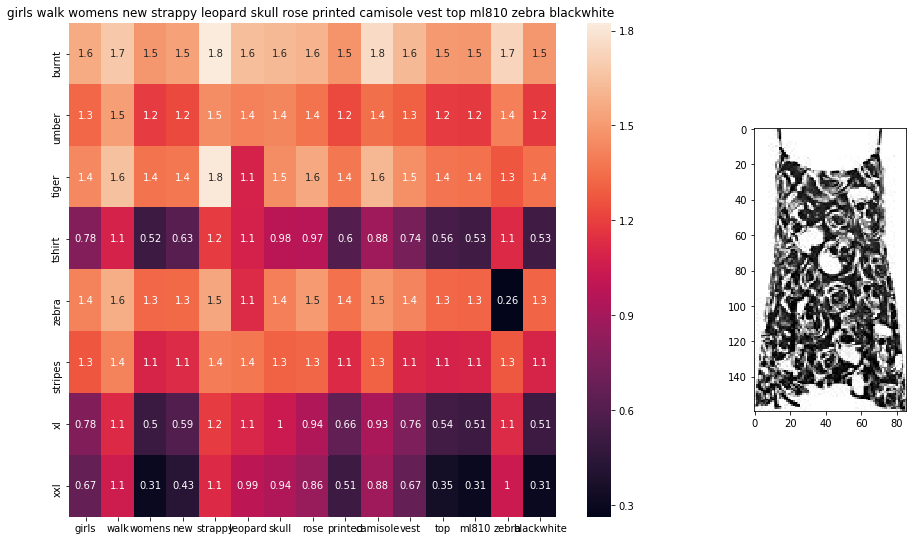

ASIN : B013TS9LX6
Brand : GirlsWalk
euclidean distance from input : 0.40549734


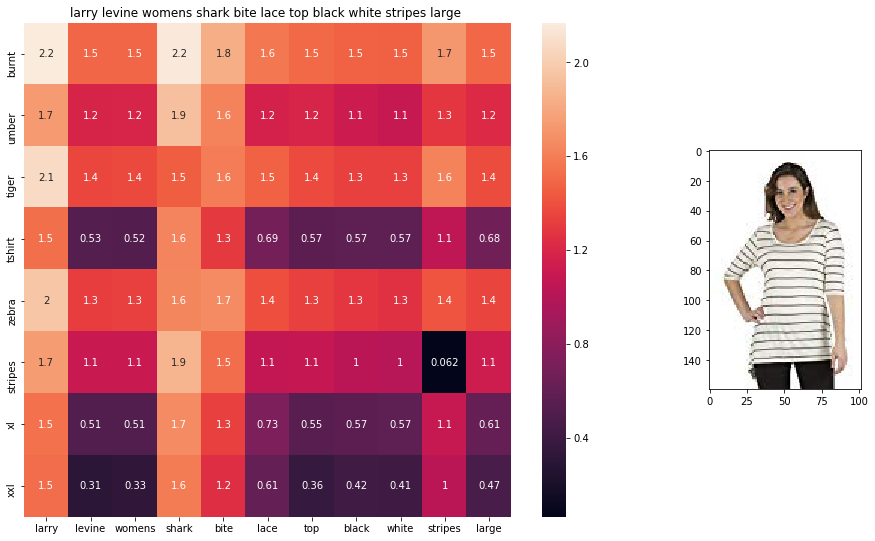

ASIN : B0754PZGYS
Brand : LARRY LEVINE
euclidean distance from input : 0.40579525


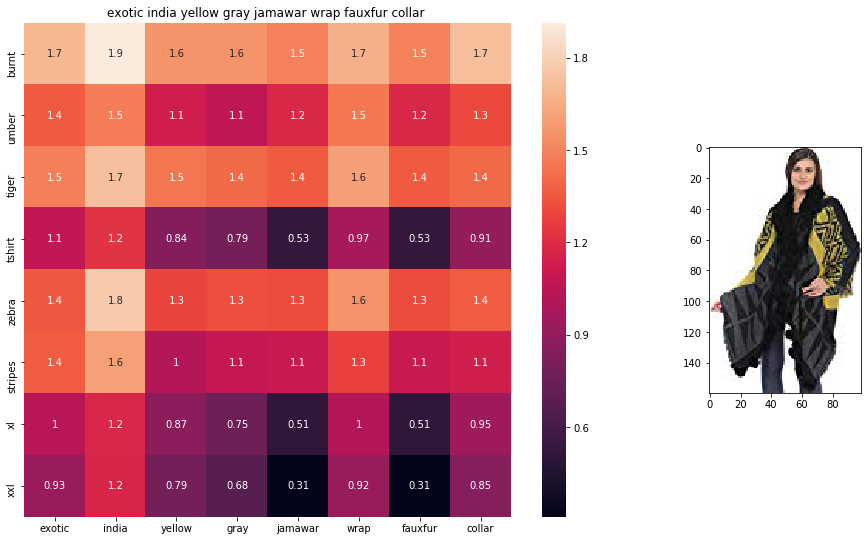

ASIN : B073ZHRBV8
Brand : Exotic India
euclidean distance from input : 0.40594438


In [161]:
weighted_w2v_model(12566, 20)

## Using Remaining Features

In [162]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [164]:
from scipy.sparse import hstack

data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [170]:
def heat_map_w2v_brand(s1, s2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    s1_vec = get_wordvec(s1, doc_id1, model)
    s2_vec = get_wordvec(s2, doc_id2, model)
    s1_s2_dist = get_dist(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    plotly.offline.iplot(table, filename='simple_table')
    
    
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
   #Plot 1
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    ax1.set_xticklabels(s2.split())
    ax1.set_yticklabels(s1.split())
    ax1.set_title(s2)
    #Plot2
    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    display_image(url, ax2, fig)
    plt.show()

In [177]:
def tfidf_w2v_brand(doc_id, w1, w2, num_results):
    tfidf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * tfidf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

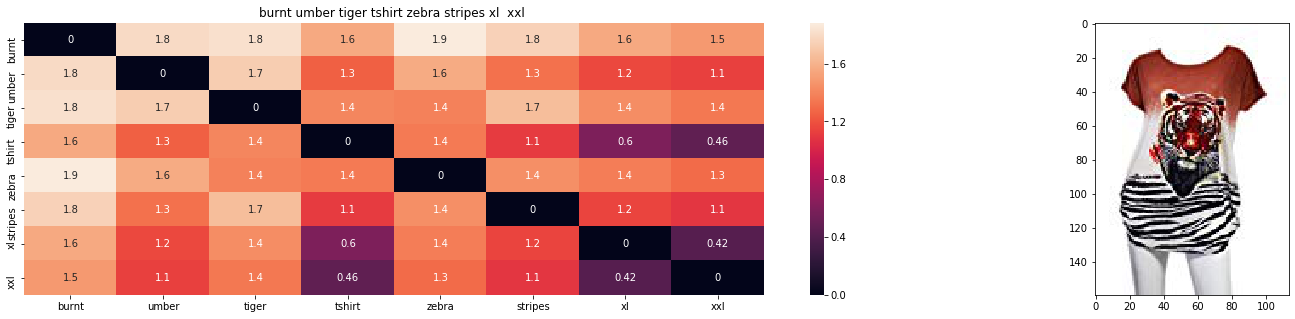

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


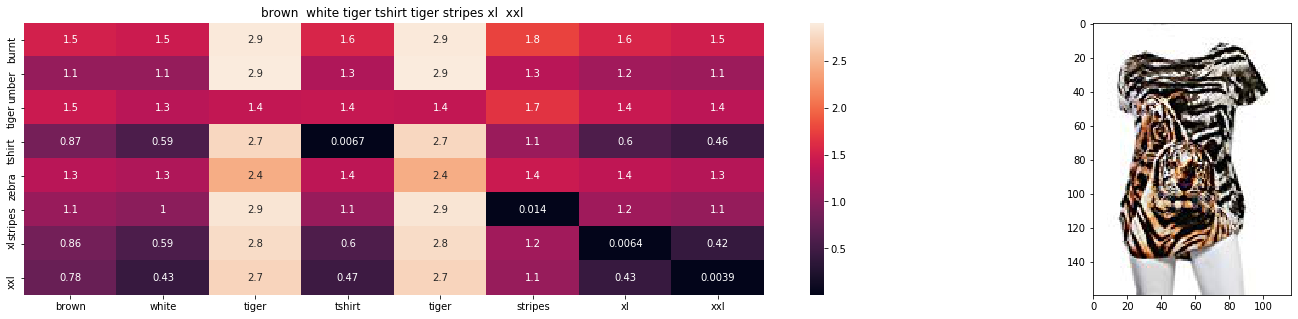

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 0.24994297027587892


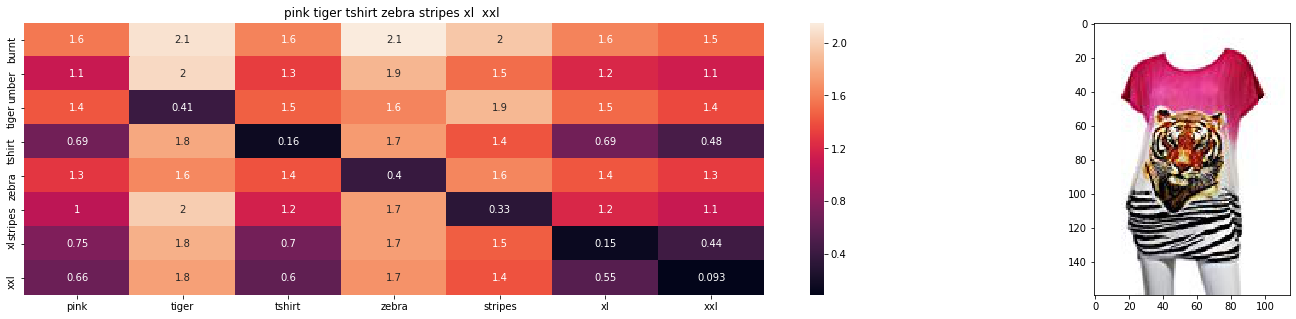

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 0.8487493993658688


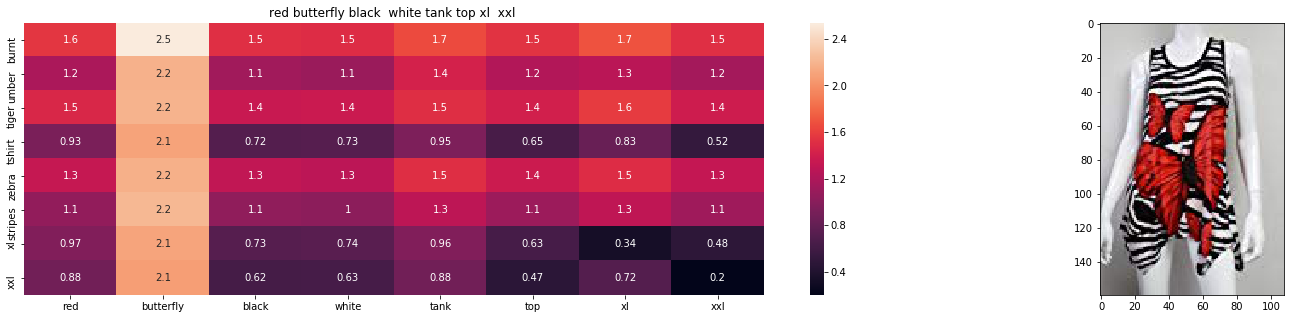

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 0.9242628814596798


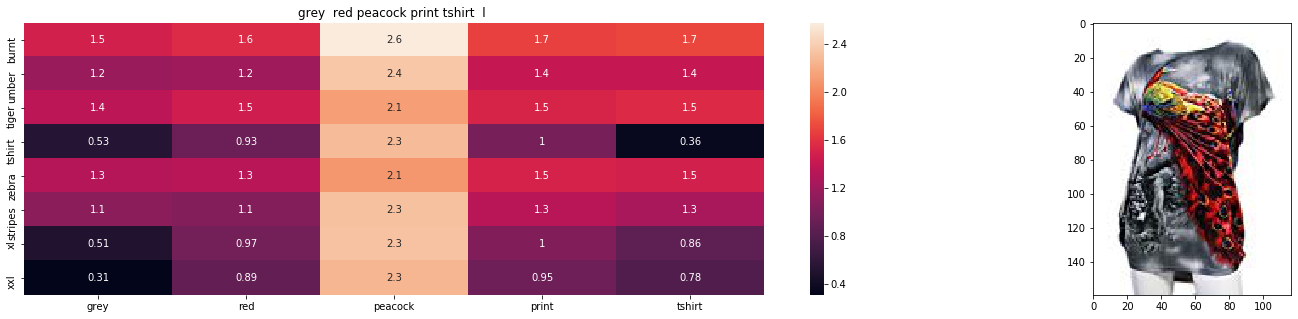

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 0.9337440969366696


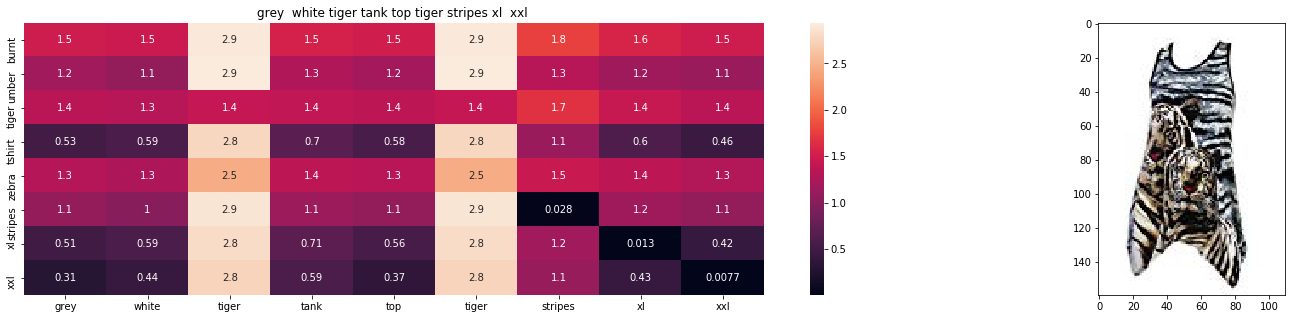

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 0.935650944890466


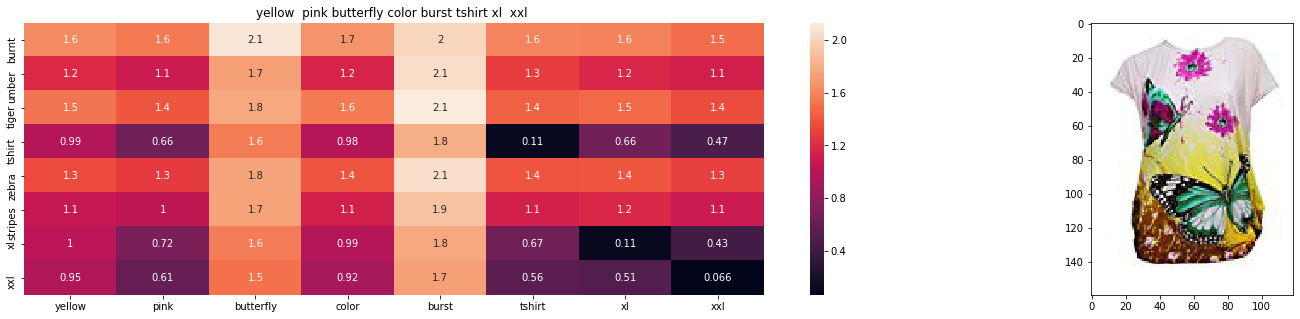

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 0.9385282995123532


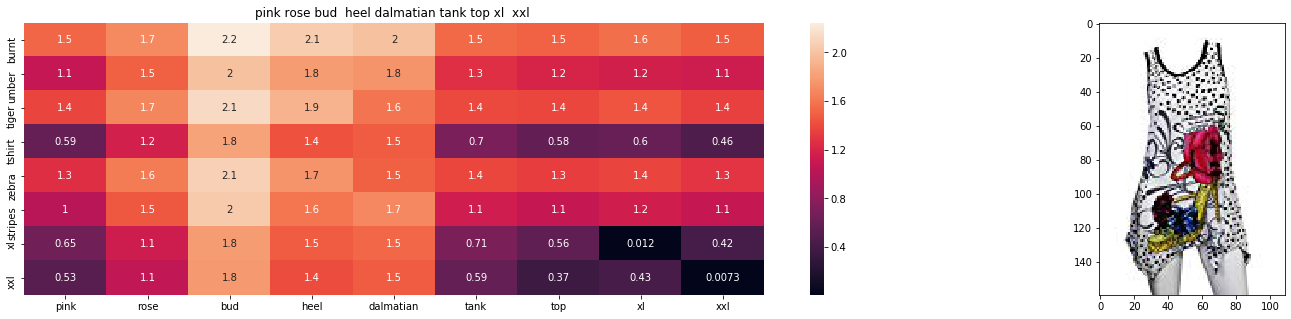

ASIN : B00JXQAX2C
Brand : Si Row
euclidean distance from input : 0.9426501037497189


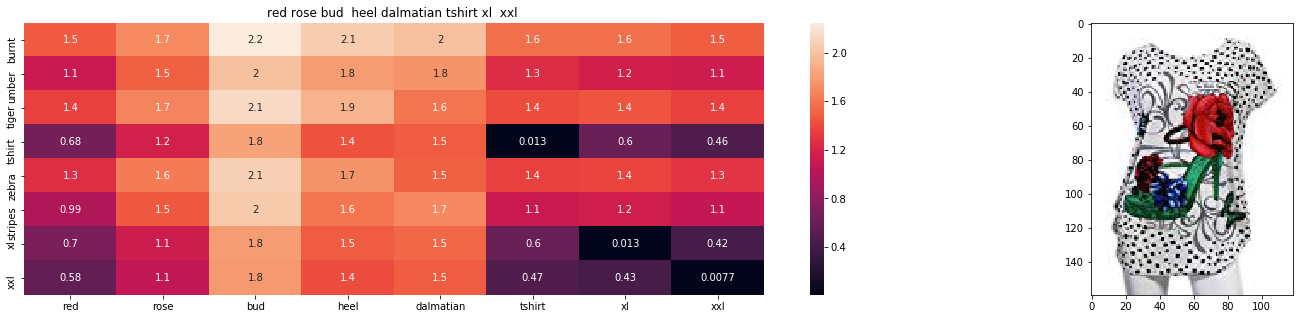

ASIN : B00JXQABB0
Brand : Si Row
euclidean distance from input : 0.948720956029382


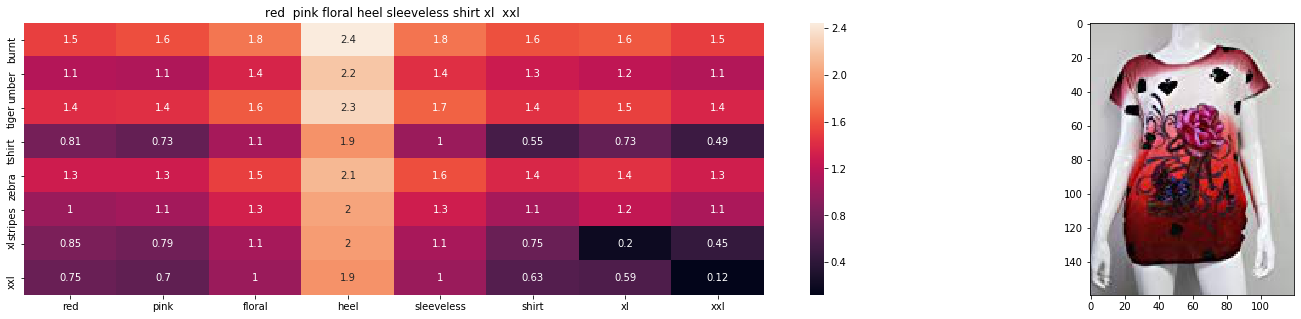

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 0.9604007245916989


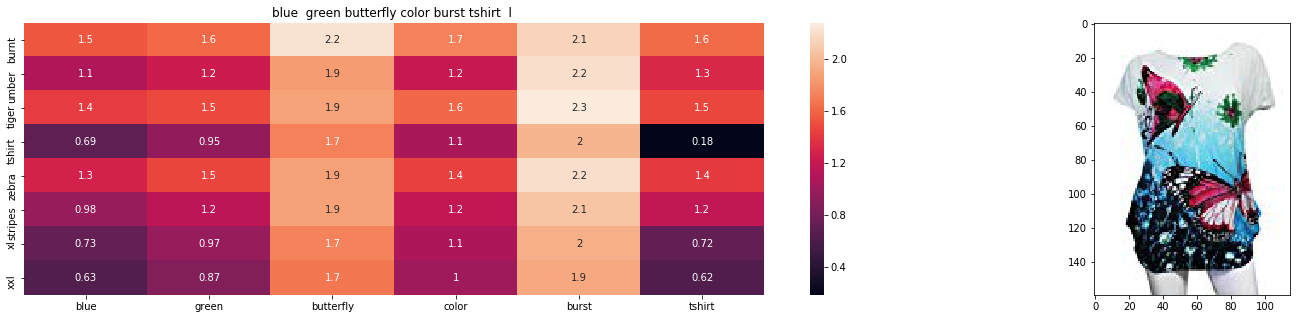

ASIN : B00JXQC0C8
Brand : Si Row
euclidean distance from input : 0.9741361619848874


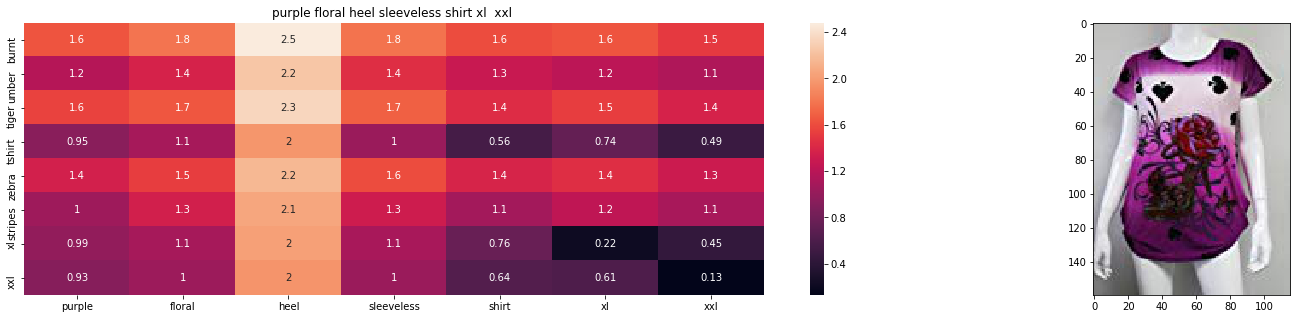

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from input : 0.9857504846472409


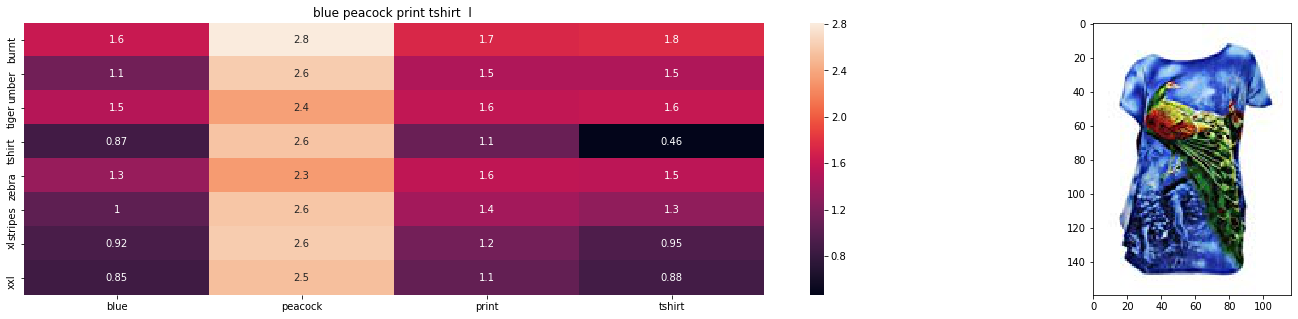

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 0.9947362424749997


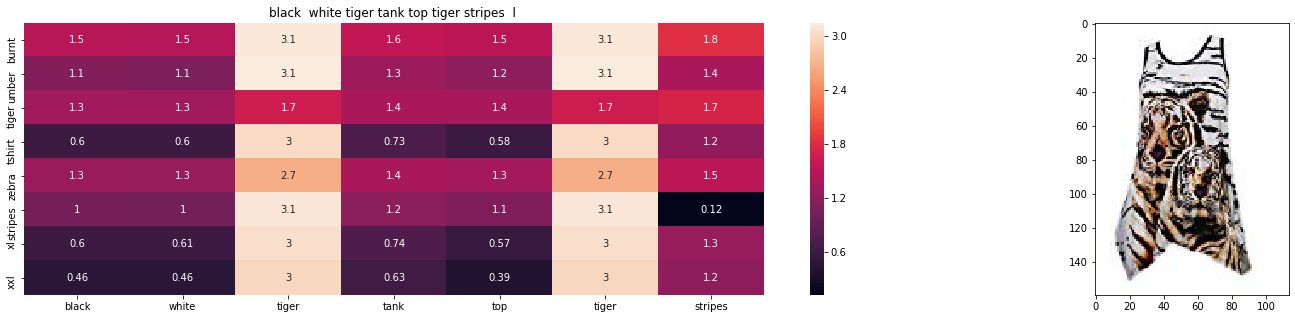

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 0.9990248681921627


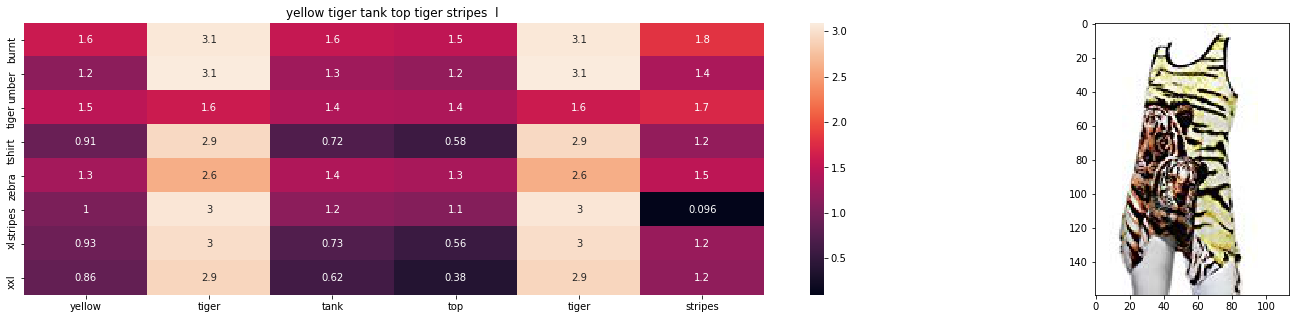

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 1.0356391193289425


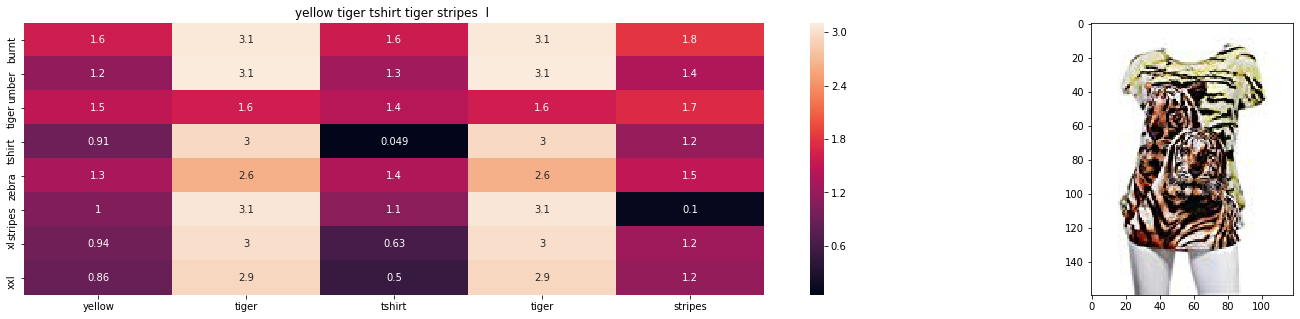

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 1.0978946210760738


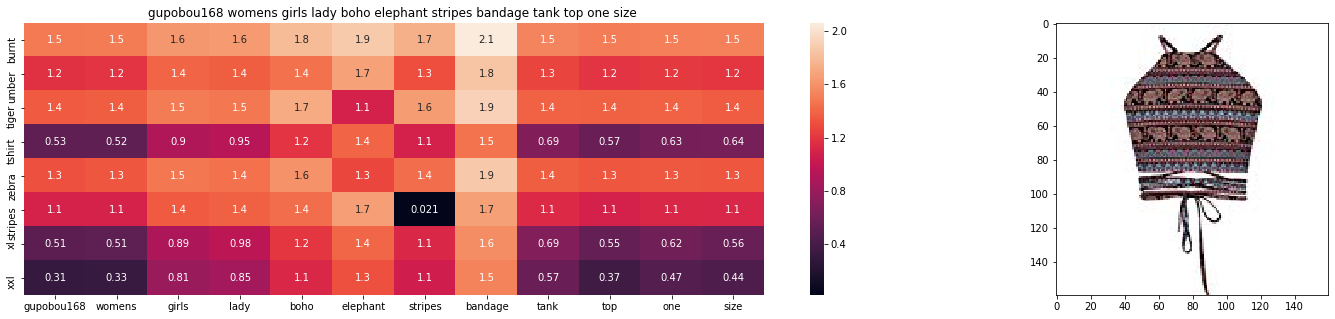

ASIN : B01ER184O6
Brand : GuPoBoU168
euclidean distance from input : 1.3230253770708178


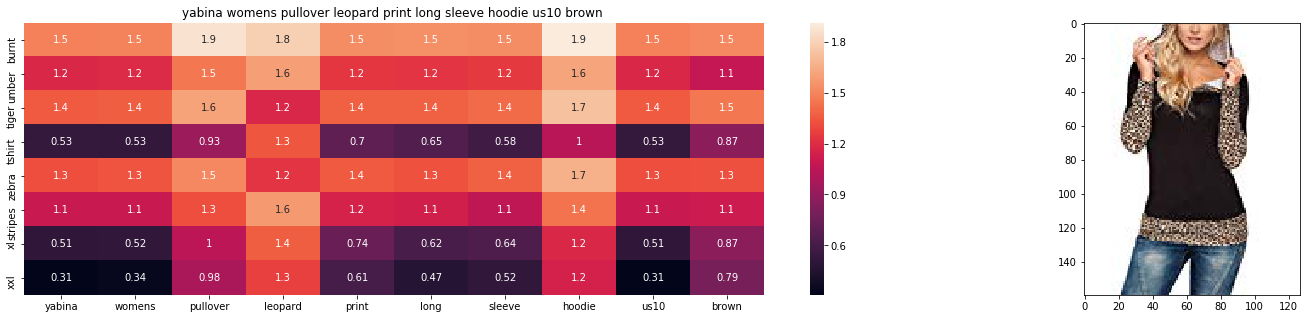

ASIN : B01KJUM6JI
Brand : YABINA
euclidean distance from input : 1.3320927217363452


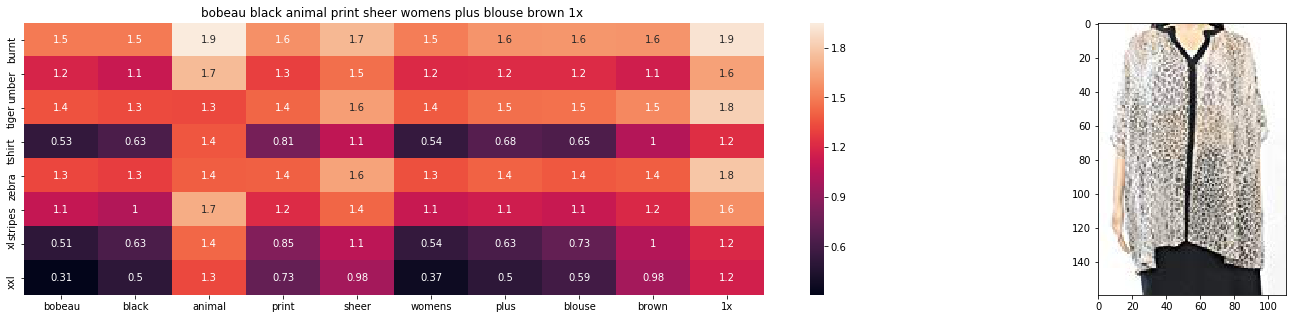

ASIN : B074MH886R
Brand : Bobeau
euclidean distance from input : 1.3371442630647752


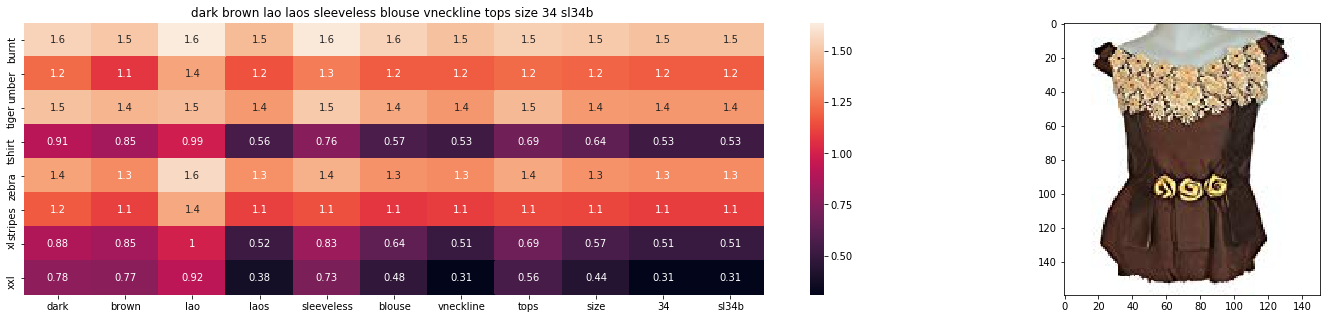

ASIN : B074J48RGW
Brand : Nanon
euclidean distance from input : 1.3382399871706103


In [178]:
tfidf_w2v_brand(12566, 5, 5, 20)